In [2]:
import wandb
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import json
from pathlib import Path
from typing import Dict
from textwrap import wrap

from lmc.logging.plot_utils import *
from lmc.logging import *
from lmc.logging.report_utils import mean_std
from lmc.logging.wandb_utils import get_timeseries_metrics_from_wandb
from importlib import reload
from lmc.utils import Step
import re
import wandb
from lmc.logging.wandb_utils import get_merged_df
from lmc.logging.wandb_registry import WandbMetricsRegistry
from lmc.logging.plot import plot_perturb_barrier
import os

%load_ext autoreload
%autoreload 2

# Butterfly - ICML 2025


Targeting <= 0.15 train CE

Per-layer perturbations:

- [ ] conv weights only
- [ ] norm weights only: HYPOTHESIS a lot more barrier given same L2/n (n is number of parameters), and less well correlated with L2/n, this shows models are sensitive to activation distributions
- [ ] single residual blocks only (conv weights)

Training (original butterfly experiment, but controlling perturbation L2, not perturbing norm layers, etc.):

- [ ] standard training `--group=reference --lr=0.001 --warmup_ratio=0.02 --weight_decay=0 --training_steps=25000st`
- [ ] (LMC baseline) different batch orders

Architecture effects, controlling for number of parameters:

- [ ] wide/shallow: `--group=arch-wideshallow --model_name=resnet8-64 --warmup_ratio=0.02 --training_steps=25000st`
- [ ] narrow/deep: `--group=arch-narrowdeep --model_name=resnet34-16 --warmup_ratio=0.02 --training_steps=40000st`

Hparam effects:

- [ ] learning rate: `--group=lr-0.01 --lr=0.01 --training_steps=45000st`
- [ ] small batch size: `--group=bs-32 --batch_size=32 --training_steps=85000st`
- [ ] large batch size: `--group=bs-512 --batch_size=512 --training_steps=15000st`
- [ ] 10x warmup: `--group=warmup-10x --warmup_ratio=0.2 --training_steps=25000st`
- [ ] weight decay: `--group=decay-0.0001 --weight_decay=0.0001 --training_steps=20000st`
- [ ] constant LR after warmup: `--group=schedule-constant --lr_scheduler=constant --training_steps=35000st`
- [ ] adam: `--group=opt-adamw --lr=0.003 --optimizer=adamw --training_steps=20000st`


In [ ]:
API_KEY = os.environ.get(
    "DEVIN_WANDB_API_KEY", ""
)
if not API_KEY:
    raise ValueError(f"Please provide a valide API key")

os.environ["WANDB_API_KEY"] = API_KEY
wandb.login(key=API_KEY, relogin=True, force=True)

api = wandb.Api()
out = Path("out/butterfly")
out.mkdir(exist_ok=True, parents=True)

project_path = "devinkwok/2025-gsa-lmc-perturb_hparam"
runs = api.runs(
    project_path,
    filters={
        "tags": {"$nin": ["ignore", "delete"]},
        "name": {"$regex": "^(?!.*lyapunov).*"},  # Excludes names containing 'lyapunov'
    },
)

len(runs)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/gsaltintas/.netrc


1155

In [123]:
main_df, registry = get_merged_df(
    runs,
    scale_barriers=False,
    performance_aware=False,
    find_missing=False,
    return_registry=True,
)

na_filters = (
    (main_df["model1.test.accuracy"] != "null")
    & (main_df["model1.train.cross_entropy"] != "NaN")
    & (~main_df["model1.train.cross_entropy"].isna())
    & (~main_df["model2.train.cross_entropy"].isna())
    & (~main_df[registry.get_metric("lmc_loss_train_0_1").flat_name].isna())
)

merged_df = main_df[na_filters]
merged_df["perturb_step_log"] = merged_df["perturb_step"].apply(np.log)
merged_df["perturb_step_relative"] = merged_df.apply(
    lambda row: row["perturb_step"] / float(row["trainer.training_steps"]) * 100, axis=1
)
# Calculate mean and use pd.concat for efficiency
average_test_acc = (
    merged_df[["model1.test.accuracy", "model2.test.accuracy"]].mean(axis=1) * 100
).rename("average_test_acc")
average_train_acc = (
    merged_df[["model1.train.accuracy", "model2.train.accuracy"]].mean(axis=1) * 100
).rename("average_train_acc")
merged_df = pd.concat([merged_df, average_test_acc, average_train_acc], axis=1)
merged_df.loc[merged_df["perturb_step"] == -1, "perturb_step"] = 0

len(merged_df)
registry.get_metric("perm_wm_loss_train_0_1").ylabel

/Users/gsaltintas/code/thesis/clean/lmc/logging/wandb_utils.py:169: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df["trainer.opt.warmup_ratio"].fillna(0, inplace=True)
/Users/gsaltintas/code/thesis/clean/lmc/logging/wandb_utils.py:170: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'null' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  merged_df.fillna("null", inplace=True)
/var/folders/8n/l2sy_xn

'$\\mathcal{B}^{Wm}_{CE_\\mathrm{Tr}}$'

## Some Exploration


In [58]:
merged_df["run.group"].unique()
# merged_df["run.name"]

array(['warmup-10x-lyapunov', 'arch-wideshallow-lyapunov',
       'standard-lyapunov', 'opt-adamw-sanity', 'no-decay-sanity',
       'arch-wideshallow-sanity', 'combo-wsup-sanity', 'bs-512-sanity',
       'warmup-10x-sanity', 'standard-sanity'], dtype=object)

In [59]:
indices = [
    "run.group",
    "model.model_name",
    "trainer.opt.optimizer",
    "trainer.opt.lr",
    "trainer.opt.warmup_ratio",
    "trainer.training_steps",
    "trainer.opt.lr_scheduler",
    "trainer.opt.weight_decay",
    "data.batch_size",
    "dont_perturb_module_patterns",
    "perturb_step",
    "perturb_scale",
    "perturb_mode",
]
pv = merged_df.pivot_table(
    index=indices,
    #                       columns=["model.optimizer", "model.lr"],
    #                        values=['Train', 'Test'],
    values=[
        registry.get_metric("lmc_loss_train_0_1").flat_name,
        "model1.train.cross_entropy",
        "average_test_acc",
    ],
    # values=['Train', 'Test', "count"],
    aggfunc=["count", mean_std],
    # aggfunc=["count"],
)

pv

count  \
                                                                                                                                                                                                                                                                       average_test_acc   
run.group                 model.model_name trainer.opt.optimizer trainer.opt.lr trainer.opt.warmup_ratio trainer.training_steps trainer.opt.lr_scheduler trainer.opt.weight_decay data.batch_size dont_perturb_module_patterns perturb_step perturb_scale perturb_mode                    
arch-wideshallow-lyapunov resnet8-64       sgd                   0.1            0.02                     25000                  triangle                 0.0                      128             ['.*norm.*|.*bias.*']        0            0.0001        gaussian                    1   
                                                                                                                                                                                                                                            0.0010        gaussian                    1   
                                                                                                                                                                                                                                            0.0100        gaussian                    1   
                                                                                                                                                                                                                               500          0.0001        gaussian                    1   
                                                                                                                                                                                                                                            0.0010        gaussian                    1   
...                                                                                                                                                                                                                                                                                 ...   
warmup-10x-sanity         resnet20-32      sgd                   0.1            0.20                     25000                  triangle                 0.0                      128             ['.*norm.*|.*bias.*']        12500        0.0010        gaussian                    3   
                                                                                                                                                                                                                                            0.0030        batch                       3   
                                                                                                                                                                                                                                                          gaussian                    3   
                                                                                                                                                                                                                                            0.0100        batch                       3   
                                                                                                                                                                                                                                                          gaussian                    3   

                                                                                                                                                                                                                                                                                                                \
     

In [60]:
pv.to_csv("butterfly_icml_hparam_pivot.csv")

In [61]:
# First, let's read and process the data
grouped = (
    merged_df.groupby(["run.group", "perturb_step", "perturb_scale"])
    .agg(
        count_samples=("average_test_acc", "count"),
        model=("model.model_name", "first"),  # To see which model is used
        batch_size=("data.batch_size", "first"),
        optimizer=("trainer.opt.optimizer", "first"),
    )
    .reset_index()
)

grouped

,run.group,perturb_step,perturb_scale,count_samples,model,batch_size,optimizer
0,arch-wideshallow-lyapunov,0,0.0001,1,resnet8-64,128,sgd
1,arch-wideshallow-lyapunov,0,0.0010,1,resnet8-64,128,sgd
2,arch-wideshallow-lyapunov,0,0.0100,1,resnet8-64,128,sgd
3,arch-wideshallow-lyapunov,500,0.0001,1,resnet8-64,128,sgd
4,arch-wideshallow-lyapunov,500,0.0010,1,resnet8-64,128,sgd
...,...,...,...,...,...,...,...
202,warmup-10x-sanity,12500,0.0001,6,resnet20-32,128,sgd
203,warmup-10x-sanity,12500,0.0003,6,resnet20-32,128,sgd
204,warmup-10x-sanity,12500,0.0010,6,resnet20-32,128,sgd
205,warmup-10x-sanity,12500,0.0030,6,resnet20-32,128,sgd


## Plots


### Sanity


In [62]:
filters = pv.reset_index()["run.group"] == "standard-sanity"
pv.reset_index()[filters]

## ResNet-20, SGD with momentum, lr=0.1, warmup=0.02, triangle scheduler, wd=0.0001, bs=128, 20000 steps

run.group model.model_name trainer.opt.optimizer trainer.opt.lr  \
                                                                             
271  standard-sanity      resnet20-32                   sgd            0.1   
272  standard-sanity      resnet20-32                   sgd            0.1   
273  standard-sanity      resnet20-32                   sgd            0.1   
274  standard-sanity      resnet20-32                   sgd            0.1   
275  standard-sanity      resnet20-32                   sgd            0.1   
276  standard-sanity      resnet20-32                   sgd            0.1   
277  standard-sanity      resnet20-32                   sgd            0.1   
278  standard-sanity      resnet20-32                   sgd            0.1   
279  standard-sanity      resnet20-32                   sgd            0.1   
280  standard-sanity      resnet20-32                   sgd            0.1   
281  standard-sanity      resnet20-32                   sgd            0.1   
282  standard-sanity      resnet20-32                   sgd            0.1   
283  standard-sanity      resnet20-32                   sgd            0.1   
284  standard-sanity      resnet20-32                   sgd            0.1   
285  standard-sanity      resnet20-32                   sgd            0.1   
286  standard-sanity      resnet20-32                   sgd            0.1   
287  standard-sanity      resnet20-32                   sgd            0.1   
288  standard-sanity      resnet20-32                   sgd            0.1   
289  standard-sanity      resnet20-32                   sgd            0.1   
290  standard-sanity      resnet20-32                   sgd            0.1   
291  standard-sanity      resnet20-32                   sgd            0.1   
292  standard-sanity      resnet20-32                   sgd            0.1   
293  standard-sanity      resnet20-32                   sgd            0.1   
294  standard-sanity      resnet20-32                   sgd            0.1   
295  standard-sanity      resnet20-32                   sgd            0.1   
296  standard-sanity      resnet20-32                   sgd            0.1   
297  standard-sanity      resnet20-32                   sgd            0.1   
298  standard-sanity      resnet20-32                   sgd            0.1   
299  standard-sanity      resnet20-32                   sgd            0.1   
300  standard-sanity      resnet20-32                   sgd            0.1   
301  standard-sanity      resnet20-32                   sgd            0.1   
302  standard-sanity      resnet20-32                   sgd            0.1   
303  standard-sanity      resnet20-32                   sgd            0.1   
304  standard-sanity      resnet20-32                   sgd            0.1   
305  standard-sanity      resnet20-32                   sgd            0.1   
306  standard-sanity      resnet20-32                   sgd            0.1   
307  standard-sanity      resnet20-32                   sgd            0.1   
308  standard-sanity      resnet20-32                   sgd            0.1   
309  standard-sanity      resnet20-32                   sgd            0.1   
310  standard-sanity      resnet20-32                   sgd            0.1   
311  standard-sanity      resnet20-32                   sgd            0.1   
312  standard-sanity      resnet20-32                   sgd            0.1   
313  standard-sanity      resnet20-32                   sgd            0.1   
314  standard-sanity      resnet20-32                   sgd            0.1   
315  standard-sanity      resnet20-32                   sgd            0.1   
316  standard-sanity      resnet20-32                   sgd            0.1   
317  standard-sanity      resnet20-32                   sgd            0.1   
318  standard-sanity      resnet20-32                   sgd            0.1   
319  standard-sanity      resnet20-32                   sgd            0.1   
320  standard-sanity      resnet2

In [63]:
registry.get_metric("perm_wm_loss_train_0_1").ylabel

'$\\mathcal{B}^{Wm}_{CE_\\mathrm{Tr}}$'

85
hello perturb_scale perturb_scale False


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


Saved legend to out/butterfly/standard-sanity-batch-lmc-0-1-loss-weighted-barrier-legend.pdf
Saved figure to out/butterfly/standard-sanity-batch-lmc-0-1-loss-weighted-barrier.pdf


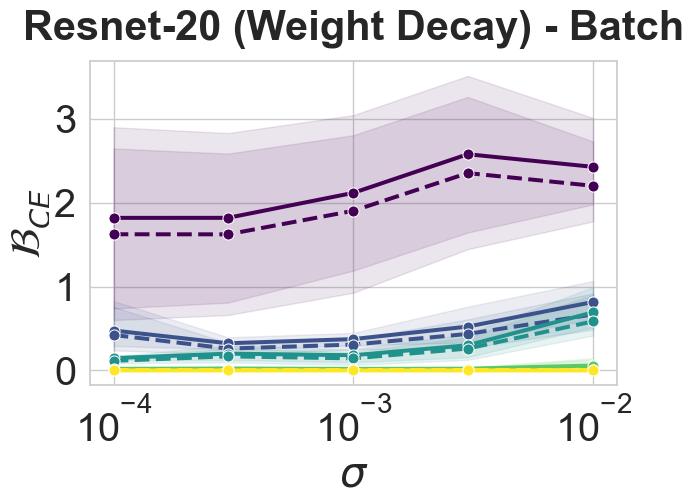

<Figure size 680.78x420.745 with 0 Axes>

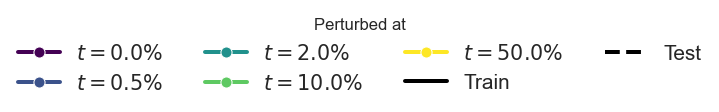

85
hello perturb_scale perturb_scale False


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


Saved legend to out/butterfly/standard-sanity-batch-perm-wm-0-1-loss-weighted-barrier-legend.pdf
Saved figure to out/butterfly/standard-sanity-batch-perm-wm-0-1-loss-weighted-barrier.pdf


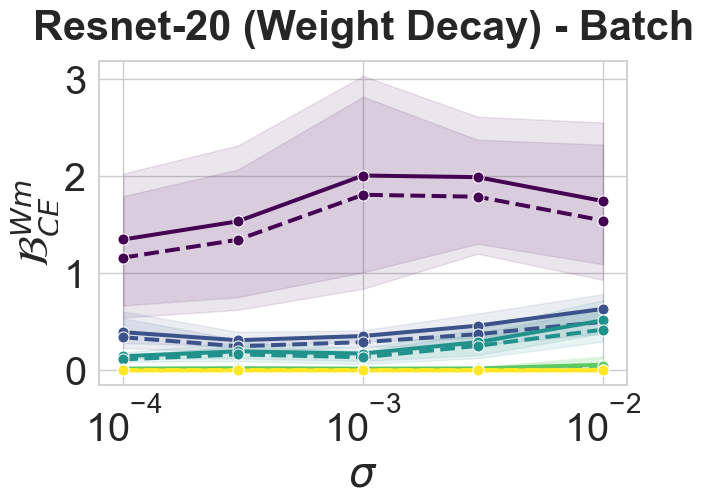

<Figure size 680.78x420.745 with 0 Axes>

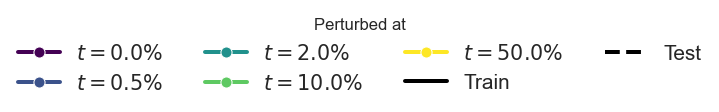

77
hello perturb_scale perturb_scale False


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


Saved legend to out/butterfly/standard-sanity-gaussian-lmc-0-1-loss-weighted-barrier-legend.pdf
Saved figure to out/butterfly/standard-sanity-gaussian-lmc-0-1-loss-weighted-barrier.pdf


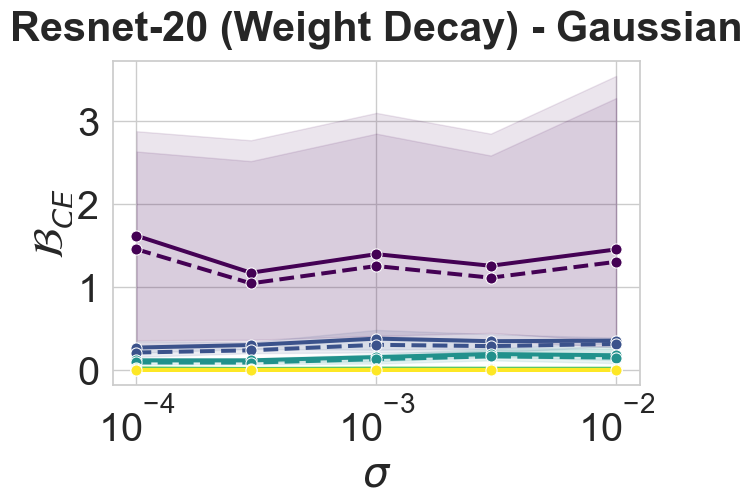

<Figure size 680.78x420.745 with 0 Axes>

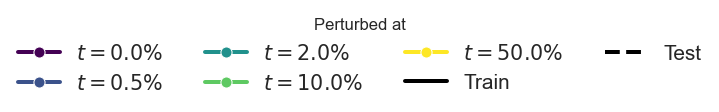

77
hello perturb_scale perturb_scale False


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


Saved legend to out/butterfly/standard-sanity-gaussian-perm-wm-0-1-loss-weighted-barrier-legend.pdf
Saved figure to out/butterfly/standard-sanity-gaussian-perm-wm-0-1-loss-weighted-barrier.pdf


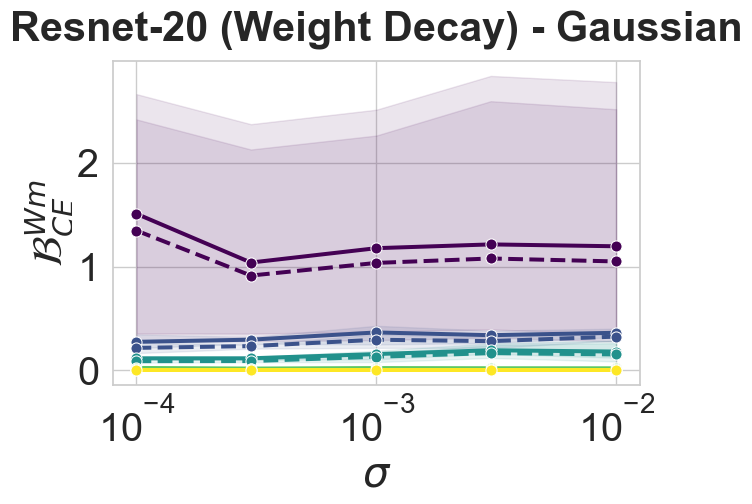

<Figure size 680.78x420.745 with 0 Axes>

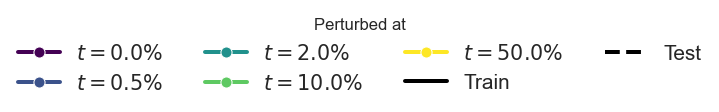

In [64]:
group = "standard-sanity"
filters = merged_df["run.group"] == group
for perturb_method in ["batch", "gaussian"]:
    for base_prefix in ["lmc", "perm_wm"]:
        base_name = f"{base_prefix}_loss_train_0_1"
        zoom = None
        x_metric = "perturb_scale"
        legend_template = r"$t={} \%$"
        labels = ["perturb_step_relative"]

        tmp = merged_df[filters & (merged_df["perturb_mode"] == perturb_method)]
        print(len(tmp))
        title = f"ResNet-20 (Weight Decay) - {perturb_method}".title()
        t = plot_perturb_barrier(
            tmp,
            registry,
            perturb_method,
            base_name,
            zoom=zoom,
            filter_bad_runs=False,
            separate_legend=True,
            plot_type="line",
            title=title,
            x_metric=x_metric,
            labels=labels,
            legend_template=legend_template,
            legend_title="Perturbed at",
            hue_cnt=5,
            ncols=4,
            save_fig=True,
            xscale="log",
            save_prefix=group,
            out_dir=out,
        )

In [ ]:
## parameter distance

### AdamW


In [78]:
filters = pv.reset_index()["run.group"] == "opt-adamw-sanity"
pv.reset_index()[filters].head()

## ResNet-20, ADAMW, lr=0.003, warmup=0.02, triangle scheduler, bs=128, 20000 steps, wd=0

run.group model.model_name trainer.opt.optimizer trainer.opt.lr  \
                                                                              
210  opt-adamw-sanity      resnet20-32                 adamw          0.003   
211  opt-adamw-sanity      resnet20-32                 adamw          0.003   
212  opt-adamw-sanity      resnet20-32                 adamw          0.003   
213  opt-adamw-sanity      resnet20-32                 adamw          0.003   
214  opt-adamw-sanity      resnet20-32                 adamw          0.003   

    trainer.opt.warmup_ratio trainer.training_steps trainer.opt.lr_scheduler  \
                                                                               
210                     0.02                  20000                 triangle   
211                     0.02                  20000                 triangle   
212                     0.02                  20000                 triangle   
213                     0.02                  20000                 triangle   
214                     0.02                  20000                 triangle   

    trainer.opt.weight_decay data.batch_size dont_perturb_module_patterns  \
                                                                            
210                      0.0             128        ['.*norm.*|.*bias.*']   
211                      0.0             128        ['.*norm.*|.*bias.*']   
212                      0.0             128        ['.*norm.*|.*bias.*']   
213                      0.0             128        ['.*norm.*|.*bias.*']   
214                      0.0             128        ['.*norm.*|.*bias.*']   

    perturb_step perturb_scale perturb_mode            count  \
                                            average_test_acc   
210            0        0.0001        batch                3   
211            0        0.0001     gaussian                3   
212            0        0.0003        batch                3   
213            0        0.0003     gaussian                3   
214            0        0.0010        batch                3   

                                                                        \
    lmc-0-1.lmc.loss.weighted.barrier_train model1.train.cross_entropy   
210                                       3                          3   
211                                       3                          3   
212                                       3                          3   
213                                       3                          3   
214                                       3                          3   

            mean_std                                          \
    average_test_acc lmc-0-1.lmc.loss.weighted.barrier_train   
210     89.16 ± 0.24                             8.68 ± 1.94   
211     89.22 ± 0.29                             5.74 ± 2.94   
212     89.29 ± 0.17                             8.02 ± 0.89   
213     89.27 ± 0.14                             5.34 ± 0.21   
214     89.28 ± 0.19                            12.33 ± 6.19   

                                
    model1.train.cross_entropy  
210                0.12 ± 0.01  
211                0.13 ± 0.01  
212                0.12 ± 0.00  
213                0.12 ± 0.01  
214                0.12 ± 0.01

75
hello perturb_scale perturb_scale False


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


Saved legend to out/butterfly/opt-adamw-sanity-batch-lmc-0-1-loss-weighted-barrier-legend.pdf
Saved figure to out/butterfly/opt-adamw-sanity-batch-lmc-0-1-loss-weighted-barrier.pdf


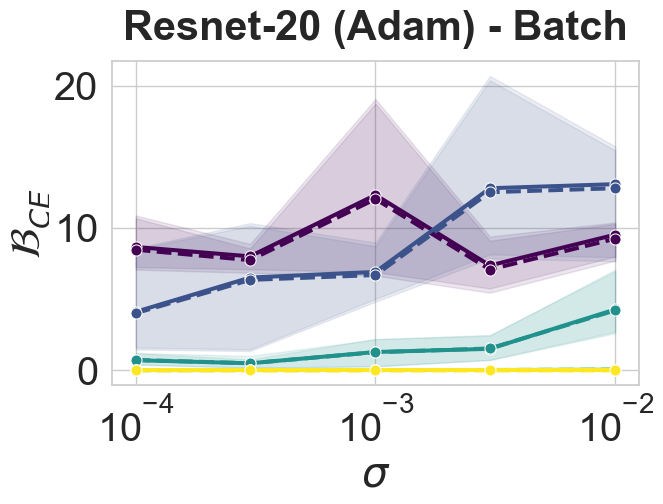

<Figure size 680.78x420.745 with 0 Axes>

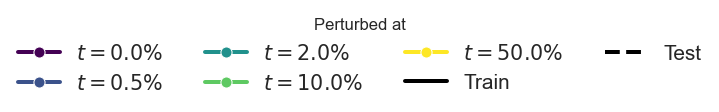

75
hello perturb_scale perturb_scale False


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


Saved legend to out/butterfly/opt-adamw-sanity-batch-perm-wm-0-1-loss-weighted-barrier-legend.pdf
Saved figure to out/butterfly/opt-adamw-sanity-batch-perm-wm-0-1-loss-weighted-barrier.pdf


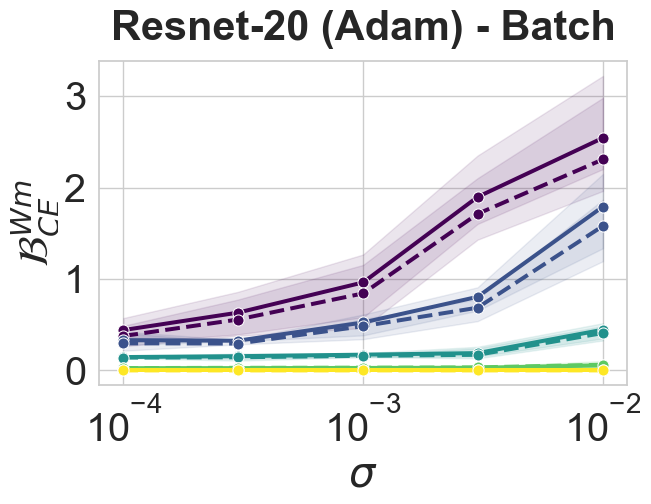

<Figure size 680.78x420.745 with 0 Axes>

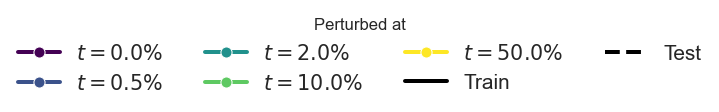

75
hello perturb_scale perturb_scale False


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


Saved legend to out/butterfly/opt-adamw-sanity-gaussian-lmc-0-1-loss-weighted-barrier-legend.pdf
Saved figure to out/butterfly/opt-adamw-sanity-gaussian-lmc-0-1-loss-weighted-barrier.pdf


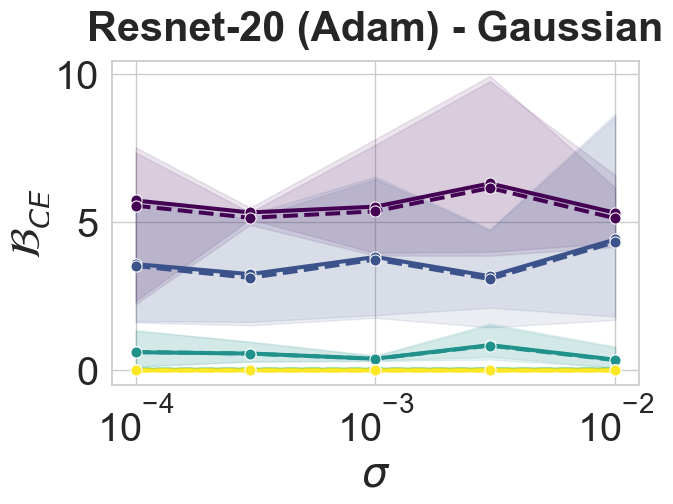

<Figure size 680.78x420.745 with 0 Axes>

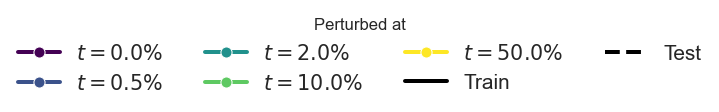

75
hello perturb_scale perturb_scale False


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


Saved legend to out/butterfly/opt-adamw-sanity-gaussian-perm-wm-0-1-loss-weighted-barrier-legend.pdf
Saved figure to out/butterfly/opt-adamw-sanity-gaussian-perm-wm-0-1-loss-weighted-barrier.pdf


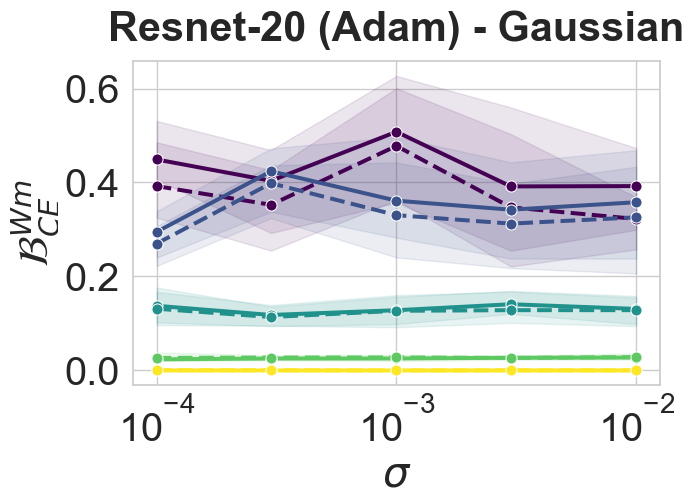

<Figure size 680.78x420.745 with 0 Axes>

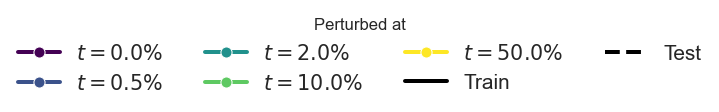

In [66]:
group = "opt-adamw-sanity"
filters = merged_df["run.group"] == group
for perturb_method in ["batch", "gaussian"]:
    for base_prefix in ["lmc", "perm_wm"]:
        base_name = f"{base_prefix}_loss_train_0_1"
        zoom = None
        x_metric = "perturb_scale"
        legend_template = r"$t={} \%$"
        labels = ["perturb_step_relative"]

        tmp = merged_df[filters & (merged_df["perturb_mode"] == perturb_method)]
        print(len(tmp))
        title = f"ResNet-20 (Adam) - {perturb_method}".title()
        t = plot_perturb_barrier(
            tmp,
            registry,
            perturb_method,
            base_name,
            zoom=zoom,
            filter_bad_runs=False,
            separate_legend=True,
            plot_type="line",
            title=title,
            x_metric=x_metric,
            labels=labels,
            legend_template=legend_template,
            legend_title="Perturbed at",
            # legend_title="Perturb step, Start checkpoint",
            hue_cnt=5,
            ncols=4,
            save_fig=True,
            xscale="log",
            save_prefix=group,
            out_dir=out,
        )

### BS=512


In [67]:
filters = pv.reset_index()["run.group"] == "bs-512-sanity"
pv.reset_index()[filters]

## ResNet-20, SGD, lr=0.1, warmup=0.02, triangle scheduler, bs=512, 10000 steps, wd=0

run.group model.model_name trainer.opt.optimizer trainer.opt.lr  \
                                                                           
60   bs-512-sanity      resnet20-32                   sgd            0.1   
61   bs-512-sanity      resnet20-32                   sgd            0.1   
62   bs-512-sanity      resnet20-32                   sgd            0.1   
63   bs-512-sanity      resnet20-32                   sgd            0.1   
64   bs-512-sanity      resnet20-32                   sgd            0.1   
65   bs-512-sanity      resnet20-32                   sgd            0.1   
66   bs-512-sanity      resnet20-32                   sgd            0.1   
67   bs-512-sanity      resnet20-32                   sgd            0.1   
68   bs-512-sanity      resnet20-32                   sgd            0.1   
69   bs-512-sanity      resnet20-32                   sgd            0.1   
70   bs-512-sanity      resnet20-32                   sgd            0.1   
71   bs-512-sanity      resnet20-32                   sgd            0.1   
72   bs-512-sanity      resnet20-32                   sgd            0.1   
73   bs-512-sanity      resnet20-32                   sgd            0.1   
74   bs-512-sanity      resnet20-32                   sgd            0.1   
75   bs-512-sanity      resnet20-32                   sgd            0.1   
76   bs-512-sanity      resnet20-32                   sgd            0.1   
77   bs-512-sanity      resnet20-32                   sgd            0.1   
78   bs-512-sanity      resnet20-32                   sgd            0.1   
79   bs-512-sanity      resnet20-32                   sgd            0.1   
80   bs-512-sanity      resnet20-32                   sgd            0.1   
81   bs-512-sanity      resnet20-32                   sgd            0.1   
82   bs-512-sanity      resnet20-32                   sgd            0.1   
83   bs-512-sanity      resnet20-32                   sgd            0.1   
84   bs-512-sanity      resnet20-32                   sgd            0.1   
85   bs-512-sanity      resnet20-32                   sgd            0.1   
86   bs-512-sanity      resnet20-32                   sgd            0.1   
87   bs-512-sanity      resnet20-32                   sgd            0.1   
88   bs-512-sanity      resnet20-32                   sgd            0.1   
89   bs-512-sanity      resnet20-32                   sgd            0.1   
90   bs-512-sanity      resnet20-32                   sgd            0.1   
91   bs-512-sanity      resnet20-32                   sgd            0.1   
92   bs-512-sanity      resnet20-32                   sgd            0.1   
93   bs-512-sanity      resnet20-32                   sgd            0.1   
94   bs-512-sanity      resnet20-32                   sgd            0.1   
95   bs-512-sanity      resnet20-32                   sgd            0.1   
96   bs-512-sanity      resnet20-32                   sgd            0.1   
97   bs-512-sanity      resnet20-32                   sgd            0.1   
98   bs-512-sanity      resnet20-32                   sgd            0.1   
99   bs-512-sanity      resnet20-32                   sgd            0.1   
100  bs-512-sanity      resnet20-32                   sgd            0.1   
101  bs-512-sanity      resnet20-32                   sgd            0.1   
102  bs-512-sanity      resnet20-32                   sgd            0.1   
103  bs-512-sanity      resnet20-32                   sgd            0.1   
104  bs-512-sanity      resnet20-32                   sgd            0.1   
105  bs-512-sanity      resnet20-32                   sgd            0.1   
106  bs-512-sanity      resnet20-32                   sgd            0.1   
107  bs-512-sanity      resnet20-32                   sgd            0.1   
108  bs-512-sanity      resnet20-32                   sgd            0.1   
109  bs-512-sanity      resnet20-32                   sgd            0.1   

    trainer.opt.warmup_ratio trainer.training_steps trai

75
hello perturb_scale perturb_scale False


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


Saved legend to out/butterfly/bs-512-sanity-batch-lmc-0-1-loss-weighted-barrier-legend.pdf
Saved figure to out/butterfly/bs-512-sanity-batch-lmc-0-1-loss-weighted-barrier.pdf


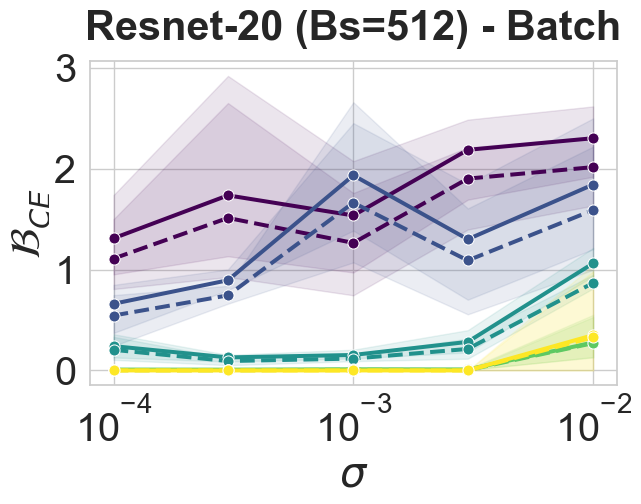

<Figure size 680.78x420.745 with 0 Axes>

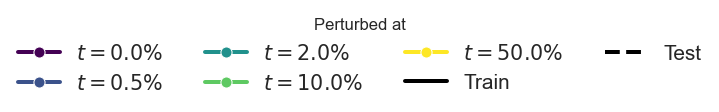

75
hello perturb_scale perturb_scale False


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


Saved legend to out/butterfly/bs-512-sanity-batch-perm-wm-0-1-loss-weighted-barrier-legend.pdf
Saved figure to out/butterfly/bs-512-sanity-batch-perm-wm-0-1-loss-weighted-barrier.pdf


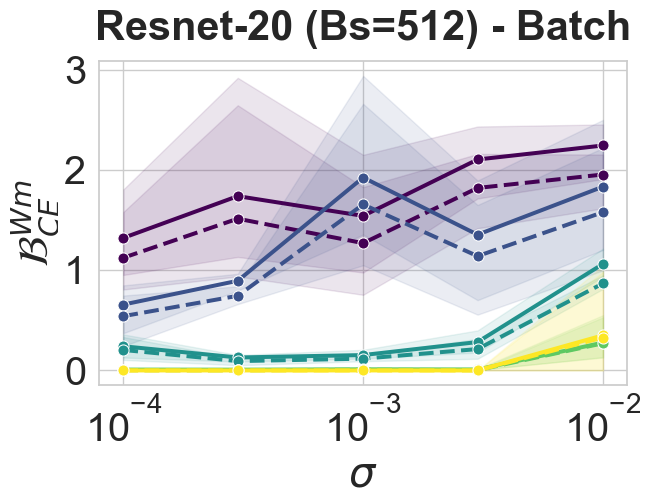

<Figure size 680.78x420.745 with 0 Axes>

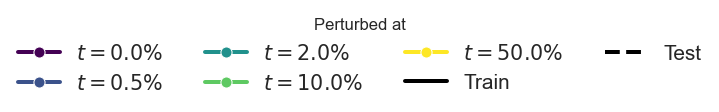

75
hello perturb_scale perturb_scale False


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


Saved legend to out/butterfly/bs-512-sanity-gaussian-lmc-0-1-loss-weighted-barrier-legend.pdf
Saved figure to out/butterfly/bs-512-sanity-gaussian-lmc-0-1-loss-weighted-barrier.pdf


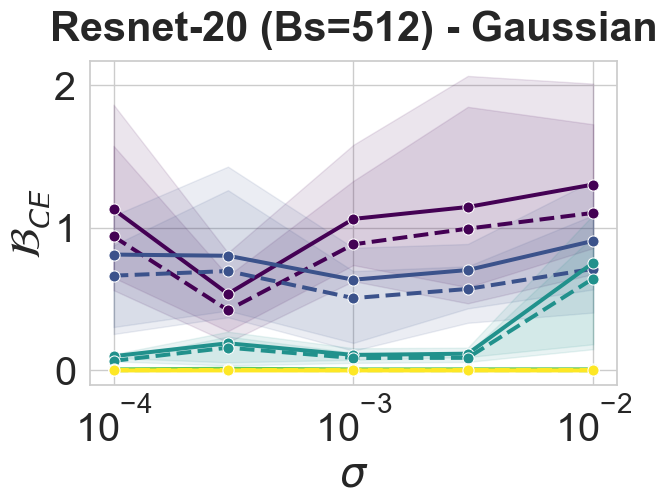

<Figure size 680.78x420.745 with 0 Axes>

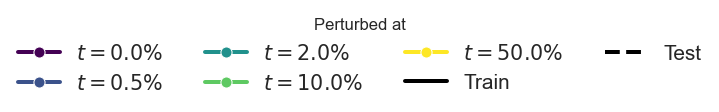

75
hello perturb_scale perturb_scale False


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


Saved legend to out/butterfly/bs-512-sanity-gaussian-perm-wm-0-1-loss-weighted-barrier-legend.pdf
Saved figure to out/butterfly/bs-512-sanity-gaussian-perm-wm-0-1-loss-weighted-barrier.pdf


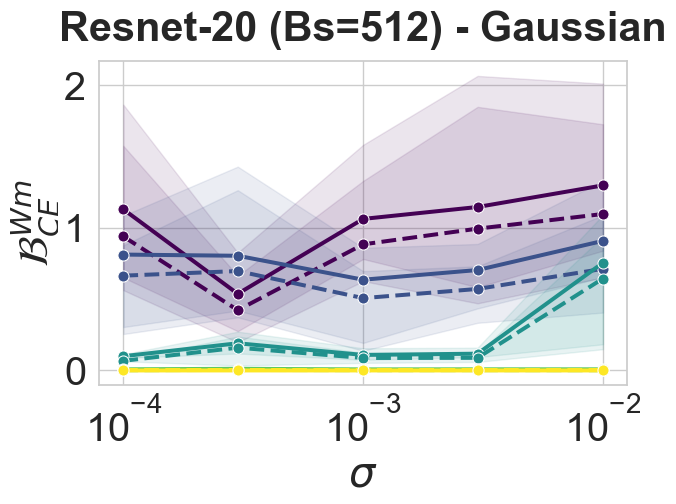

<Figure size 680.78x420.745 with 0 Axes>

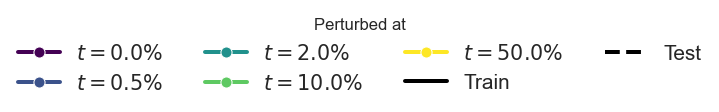

In [68]:
group = "bs-512-sanity"
filters = merged_df["run.group"] == group

for perturb_method in ["batch", "gaussian"]:
    for base_prefix in ["lmc", "perm_wm"]:
        base_name = f"{base_prefix}_loss_train_0_1"
        zoom = None
        x_metric = "perturb_scale"
        legend_template = r"$t={} \%$"
        labels = ["perturb_step_relative"]

        tmp = merged_df[filters & (merged_df["perturb_mode"] == perturb_method)]
        print(len(tmp))
        title = f"ResNet-20 (BS=512) - {perturb_method}".title()
        t = plot_perturb_barrier(
            tmp,
            registry,
            perturb_method,
            base_name,
            zoom=zoom,
            filter_bad_runs=False,
            separate_legend=True,
            plot_type="line",
            title=title,
            x_metric=x_metric,
            labels=labels,
            legend_template=legend_template,
            legend_title="Perturbed at",
            hue_cnt=5,
            ncols=4,
            save_fig=True,
            xscale="log",
            save_prefix=group,
            out_dir=out,
        )

### No Decay


In [69]:
filters = pv.reset_index()["run.group"] == "no-decay-sanity"
pv.reset_index()[filters]

## ResNet-20, SGD, lr=0.1, warmup=0.02, triangle scheduler, bs=128, 25000 steps, wd=0

run.group model.model_name trainer.opt.optimizer trainer.opt.lr  \
                                                                             
160  no-decay-sanity      resnet20-32                   sgd            0.1   
161  no-decay-sanity      resnet20-32                   sgd            0.1   
162  no-decay-sanity      resnet20-32                   sgd            0.1   
163  no-decay-sanity      resnet20-32                   sgd            0.1   
164  no-decay-sanity      resnet20-32                   sgd            0.1   
165  no-decay-sanity      resnet20-32                   sgd            0.1   
166  no-decay-sanity      resnet20-32                   sgd            0.1   
167  no-decay-sanity      resnet20-32                   sgd            0.1   
168  no-decay-sanity      resnet20-32                   sgd            0.1   
169  no-decay-sanity      resnet20-32                   sgd            0.1   
170  no-decay-sanity      resnet20-32                   sgd            0.1   
171  no-decay-sanity      resnet20-32                   sgd            0.1   
172  no-decay-sanity      resnet20-32                   sgd            0.1   
173  no-decay-sanity      resnet20-32                   sgd            0.1   
174  no-decay-sanity      resnet20-32                   sgd            0.1   
175  no-decay-sanity      resnet20-32                   sgd            0.1   
176  no-decay-sanity      resnet20-32                   sgd            0.1   
177  no-decay-sanity      resnet20-32                   sgd            0.1   
178  no-decay-sanity      resnet20-32                   sgd            0.1   
179  no-decay-sanity      resnet20-32                   sgd            0.1   
180  no-decay-sanity      resnet20-32                   sgd            0.1   
181  no-decay-sanity      resnet20-32                   sgd            0.1   
182  no-decay-sanity      resnet20-32                   sgd            0.1   
183  no-decay-sanity      resnet20-32                   sgd            0.1   
184  no-decay-sanity      resnet20-32                   sgd            0.1   
185  no-decay-sanity      resnet20-32                   sgd            0.1   
186  no-decay-sanity      resnet20-32                   sgd            0.1   
187  no-decay-sanity      resnet20-32                   sgd            0.1   
188  no-decay-sanity      resnet20-32                   sgd            0.1   
189  no-decay-sanity      resnet20-32                   sgd            0.1   
190  no-decay-sanity      resnet20-32                   sgd            0.1   
191  no-decay-sanity      resnet20-32                   sgd            0.1   
192  no-decay-sanity      resnet20-32                   sgd            0.1   
193  no-decay-sanity      resnet20-32                   sgd            0.1   
194  no-decay-sanity      resnet20-32                   sgd            0.1   
195  no-decay-sanity      resnet20-32                   sgd            0.1   
196  no-decay-sanity      resnet20-32                   sgd            0.1   
197  no-decay-sanity      resnet20-32                   sgd            0.1   
198  no-decay-sanity      resnet20-32                   sgd            0.1   
199  no-decay-sanity      resnet20-32                   sgd            0.1   
200  no-decay-sanity      resnet20-32                   sgd            0.1   
201  no-decay-sanity      resnet20-32                   sgd            0.1   
202  no-decay-sanity      resnet20-32                   sgd            0.1   
203  no-decay-sanity      resnet20-32                   sgd            0.1   
204  no-decay-sanity      resnet20-32                   sgd            0.1   
205  no-decay-sanity      resnet20-32                   sgd            0.1   
206  no-decay-sanity      resnet20-32                   sgd            0.1   
207  no-decay-sanity      resnet20-32                   sgd            0.1   
208  no-decay-sanity      resnet20-32                   sgd            0.1   
209  no-decay-sanity      resnet2

76
hello perturb_scale perturb_scale False


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


Saved legend to out/butterfly/no-decay-sanity-batch-lmc-0-1-loss-weighted-barrier-legend.pdf
Saved figure to out/butterfly/no-decay-sanity-batch-lmc-0-1-loss-weighted-barrier.pdf


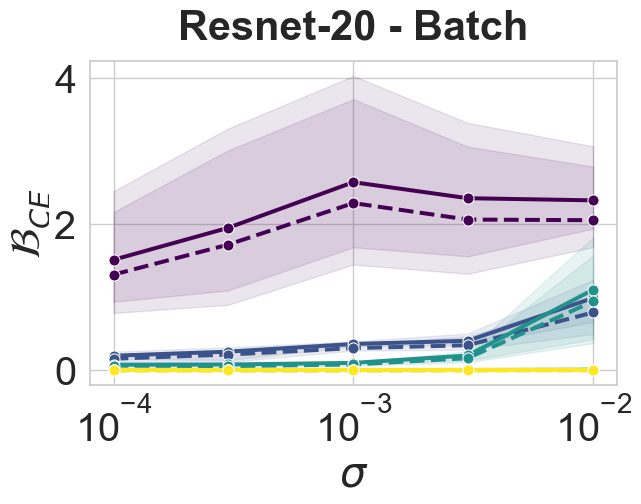

<Figure size 680.78x420.745 with 0 Axes>

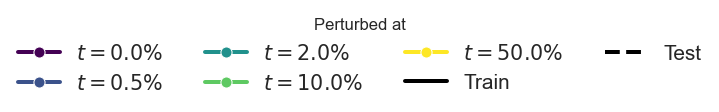

76
hello perturb_scale perturb_scale False


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


Saved legend to out/butterfly/no-decay-sanity-batch-perm-wm-0-1-loss-weighted-barrier-legend.pdf
Saved figure to out/butterfly/no-decay-sanity-batch-perm-wm-0-1-loss-weighted-barrier.pdf


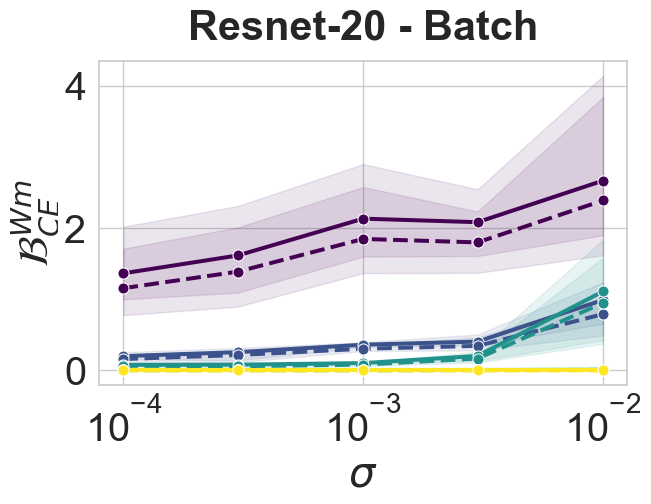

<Figure size 680.78x420.745 with 0 Axes>

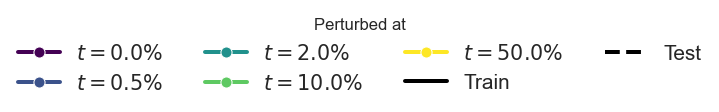

71
hello perturb_scale perturb_scale False


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


Saved legend to out/butterfly/no-decay-sanity-gaussian-lmc-0-1-loss-weighted-barrier-legend.pdf
Saved figure to out/butterfly/no-decay-sanity-gaussian-lmc-0-1-loss-weighted-barrier.pdf


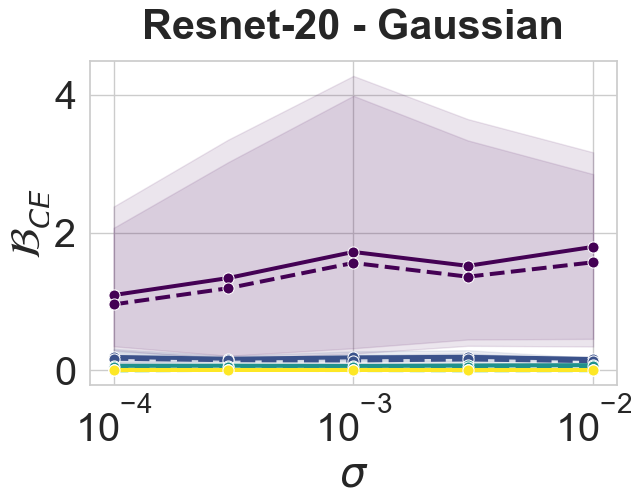

<Figure size 680.78x420.745 with 0 Axes>

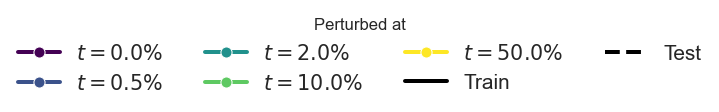

71
hello perturb_scale perturb_scale False


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


Saved legend to out/butterfly/no-decay-sanity-gaussian-perm-wm-0-1-loss-weighted-barrier-legend.pdf
Saved figure to out/butterfly/no-decay-sanity-gaussian-perm-wm-0-1-loss-weighted-barrier.pdf


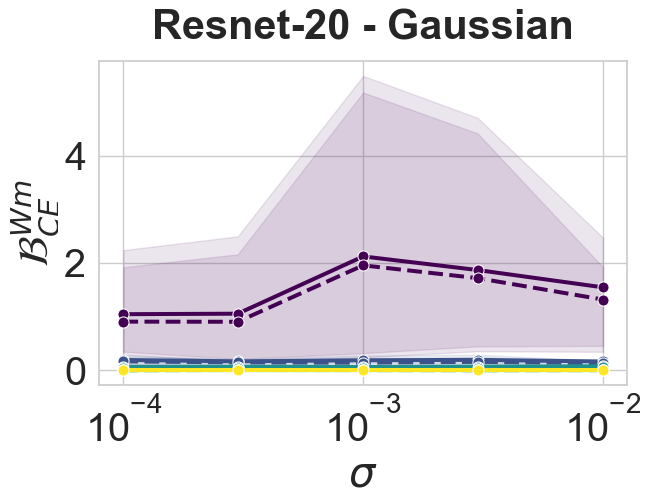

<Figure size 680.78x420.745 with 0 Axes>

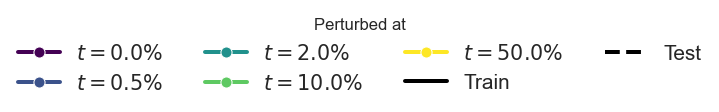

In [70]:
group = "no-decay-sanity"
filters = ((merged_df["run.group"] == group ))

for perturb_method in ["batch", "gaussian"]:
    for base_prefix in ["lmc", "perm_wm"]:
        base_name = f"{base_prefix}_loss_train_0_1"
        zoom = None
        x_metric = "perturb_scale"
        legend_template = r"$t={} \%$"
        labels = ["perturb_step_relative"]
            
        tmp = merged_df[filters & (merged_df["perturb_mode"] == perturb_method)]
        print(len(tmp))
        title = f"ResNet-20 - {perturb_method}".title()
        t = plot_perturb_barrier(
            tmp,
            registry,
            perturb_method,
            base_name,
            zoom=zoom,
            filter_bad_runs=False,
            separate_legend=True,
            plot_type="line",
            title=title,
            x_metric=x_metric,
            labels=labels,
            legend_template=legend_template,
            legend_title="Perturbed at",
            hue_cnt=5,
            ncols=4,
            save_fig=True,
            xscale="log",
            save_prefix=group,
            out_dir=out,
        )

## Arch Wide-Shallow


In [71]:
filters = pv.reset_index()["run.group"] == "arch-wideshallow-sanity"
pv.reset_index()[filters]

## ResNet-8-64, SGD, lr=0.1, warmup=0.02, triangle scheduler, bs=128, 25000 steps, wd=0

run.group model.model_name trainer.opt.optimizer  \
                                                                     
10  arch-wideshallow-sanity       resnet8-64                   sgd   
11  arch-wideshallow-sanity       resnet8-64                   sgd   
12  arch-wideshallow-sanity       resnet8-64                   sgd   
13  arch-wideshallow-sanity       resnet8-64                   sgd   
14  arch-wideshallow-sanity       resnet8-64                   sgd   
15  arch-wideshallow-sanity       resnet8-64                   sgd   
16  arch-wideshallow-sanity       resnet8-64                   sgd   
17  arch-wideshallow-sanity       resnet8-64                   sgd   
18  arch-wideshallow-sanity       resnet8-64                   sgd   
19  arch-wideshallow-sanity       resnet8-64                   sgd   
20  arch-wideshallow-sanity       resnet8-64                   sgd   
21  arch-wideshallow-sanity       resnet8-64                   sgd   
22  arch-wideshallow-sanity       resnet8-64                   sgd   
23  arch-wideshallow-sanity       resnet8-64                   sgd   
24  arch-wideshallow-sanity       resnet8-64                   sgd   
25  arch-wideshallow-sanity       resnet8-64                   sgd   
26  arch-wideshallow-sanity       resnet8-64                   sgd   
27  arch-wideshallow-sanity       resnet8-64                   sgd   
28  arch-wideshallow-sanity       resnet8-64                   sgd   
29  arch-wideshallow-sanity       resnet8-64                   sgd   
30  arch-wideshallow-sanity       resnet8-64                   sgd   
31  arch-wideshallow-sanity       resnet8-64                   sgd   
32  arch-wideshallow-sanity       resnet8-64                   sgd   
33  arch-wideshallow-sanity       resnet8-64                   sgd   
34  arch-wideshallow-sanity       resnet8-64                   sgd   
35  arch-wideshallow-sanity       resnet8-64                   sgd   
36  arch-wideshallow-sanity       resnet8-64                   sgd   
37  arch-wideshallow-sanity       resnet8-64                   sgd   
38  arch-wideshallow-sanity       resnet8-64                   sgd   
39  arch-wideshallow-sanity       resnet8-64                   sgd   
40  arch-wideshallow-sanity       resnet8-64                   sgd   
41  arch-wideshallow-sanity       resnet8-64                   sgd   
42  arch-wideshallow-sanity       resnet8-64                   sgd   
43  arch-wideshallow-sanity       resnet8-64                   sgd   
44  arch-wideshallow-sanity       resnet8-64                   sgd   
45  arch-wideshallow-sanity       resnet8-64                   sgd   
46  arch-wideshallow-sanity       resnet8-64                   sgd   
47  arch-wideshallow-sanity       resnet8-64                   sgd   
48  arch-wideshallow-sanity       resnet8-64                   sgd   
49  arch-wideshallow-sanity       resnet8-64                   sgd   
50  arch-wideshallow-sanity       resnet8-64                   sgd   
51  arch-wideshallow-sanity       resnet8-64                   sgd   
52  arch-wideshallow-sanity       resnet8-64                   sgd   
53  arch-wideshallow-sanity       resnet8-64                   sgd   
54  arch-wideshallow-sanity       resnet8-64                   sgd   
55  arch-wideshallow-sanity       resnet8-64                   sgd   
56  arch-wideshallow-sanity       resnet8-64                   sgd   
57  arch-wideshallow-sanity       resnet8-64                   sgd   
58  arch-wideshallow-sanity       resnet8-64                   sgd   
59  arch-wideshallow-sanity       resnet8-64                   sgd   

   trainer.opt.lr trainer.opt.warmup_ratio trainer.training_steps  \
                                                                    
10            0.1                     0.02                  25000   
11            0.1                     0.02                  25000   
12            0.1                     0.02                  25000   
13            0.1               

76
hello perturb_scale perturb_scale False


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


Saved legend to out/butterfly/arch-wideshallow-sanity-batch-lmc-0-1-loss-weighted-barrier-legend.pdf
Saved figure to out/butterfly/arch-wideshallow-sanity-batch-lmc-0-1-loss-weighted-barrier.pdf


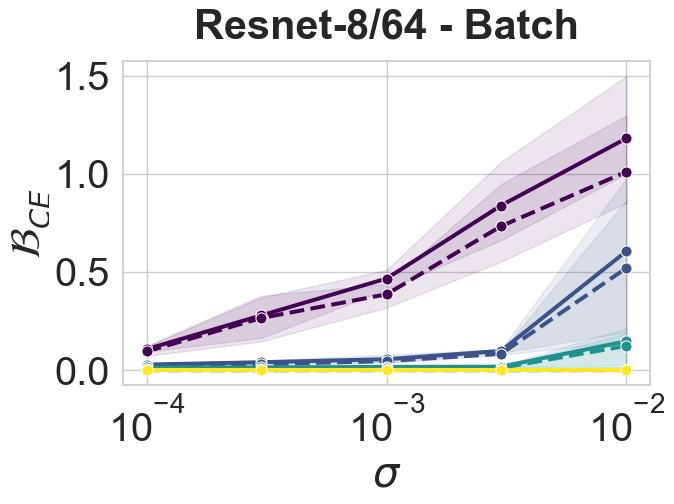

<Figure size 680.78x420.745 with 0 Axes>

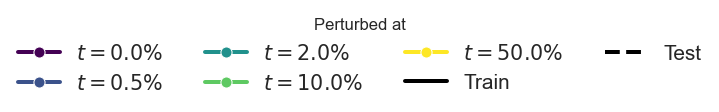

76
hello perturb_scale perturb_scale False


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


Saved legend to out/butterfly/arch-wideshallow-sanity-batch-perm-wm-0-1-loss-weighted-barrier-legend.pdf
Saved figure to out/butterfly/arch-wideshallow-sanity-batch-perm-wm-0-1-loss-weighted-barrier.pdf


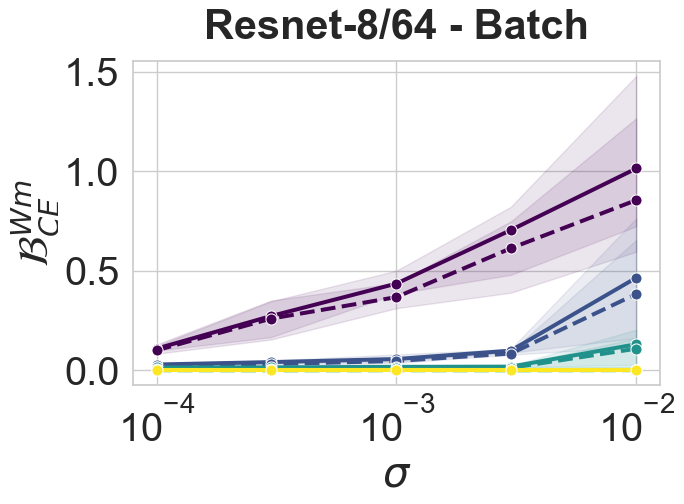

<Figure size 680.78x420.745 with 0 Axes>

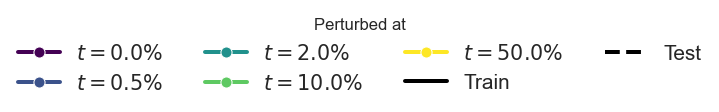

75
hello perturb_scale perturb_scale False


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


Saved legend to out/butterfly/arch-wideshallow-sanity-gaussian-lmc-0-1-loss-weighted-barrier-legend.pdf
Saved figure to out/butterfly/arch-wideshallow-sanity-gaussian-lmc-0-1-loss-weighted-barrier.pdf


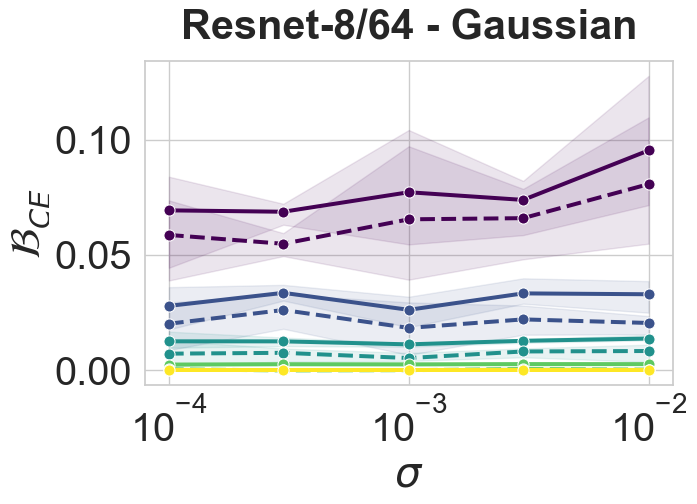

<Figure size 680.78x420.745 with 0 Axes>

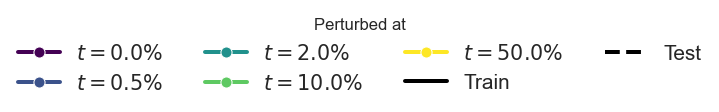

75
hello perturb_scale perturb_scale False


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


Saved legend to out/butterfly/arch-wideshallow-sanity-gaussian-perm-wm-0-1-loss-weighted-barrier-legend.pdf
Saved figure to out/butterfly/arch-wideshallow-sanity-gaussian-perm-wm-0-1-loss-weighted-barrier.pdf


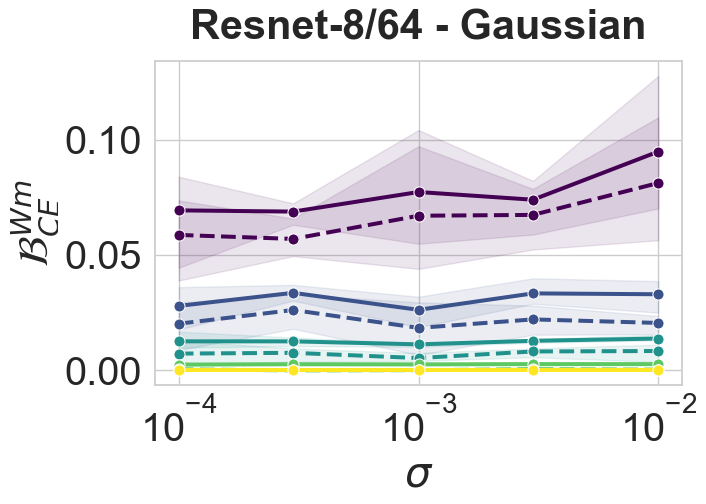

<Figure size 680.78x420.745 with 0 Axes>

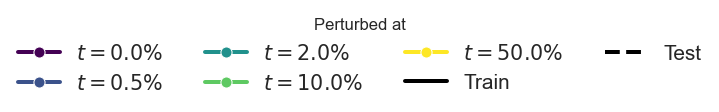

In [72]:
group = "arch-wideshallow-sanity"
filters = merged_df["run.group"] == group

for perturb_method in ["batch", "gaussian"]:
    for base_prefix in ["lmc", "perm_wm"]:
        base_name = f"{base_prefix}_loss_train_0_1"
        zoom = None
        x_metric = "perturb_scale"
        legend_template = r"$t={} \%$"
        labels = ["perturb_step_relative"]

        tmp = merged_df[filters & (merged_df["perturb_mode"] == perturb_method)]
        print(len(tmp))
        title = f"ResNet-8/64 - {perturb_method}".title()
        t = plot_perturb_barrier(
            tmp,
            registry,
            perturb_method,
            base_name,
            zoom=zoom,
            filter_bad_runs=False,
            separate_legend=True,
            plot_type="line",
            title=title,
            x_metric=x_metric,
            labels=labels,
            legend_template=legend_template,
            legend_title="Perturbed at",
            hue_cnt=5,
            ncols=4,
            save_fig=True,
            xscale="log",
            save_prefix=group,
            out_dir=out
        )

### Warmup - 10X


In [73]:
filters = pv.reset_index()["run.group"] == "warmup-10x-sanity"
pv.reset_index()[filters]

## ResNet-20, SGD, lr=0.1, warmup=0.2, triangle scheduler, bs=128, 25000 steps, wd=0

run.group model.model_name trainer.opt.optimizer trainer.opt.lr  \
                                                                               
332  warmup-10x-sanity      resnet20-32                   sgd            0.1   
333  warmup-10x-sanity      resnet20-32                   sgd            0.1   
334  warmup-10x-sanity      resnet20-32                   sgd            0.1   
335  warmup-10x-sanity      resnet20-32                   sgd            0.1   
336  warmup-10x-sanity      resnet20-32                   sgd            0.1   
337  warmup-10x-sanity      resnet20-32                   sgd            0.1   
338  warmup-10x-sanity      resnet20-32                   sgd            0.1   
339  warmup-10x-sanity      resnet20-32                   sgd            0.1   
340  warmup-10x-sanity      resnet20-32                   sgd            0.1   
341  warmup-10x-sanity      resnet20-32                   sgd            0.1   
342  warmup-10x-sanity      resnet20-32                   sgd            0.1   
343  warmup-10x-sanity      resnet20-32                   sgd            0.1   
344  warmup-10x-sanity      resnet20-32                   sgd            0.1   
345  warmup-10x-sanity      resnet20-32                   sgd            0.1   
346  warmup-10x-sanity      resnet20-32                   sgd            0.1   
347  warmup-10x-sanity      resnet20-32                   sgd            0.1   
348  warmup-10x-sanity      resnet20-32                   sgd            0.1   
349  warmup-10x-sanity      resnet20-32                   sgd            0.1   
350  warmup-10x-sanity      resnet20-32                   sgd            0.1   
351  warmup-10x-sanity      resnet20-32                   sgd            0.1   
352  warmup-10x-sanity      resnet20-32                   sgd            0.1   
353  warmup-10x-sanity      resnet20-32                   sgd            0.1   
354  warmup-10x-sanity      resnet20-32                   sgd            0.1   
355  warmup-10x-sanity      resnet20-32                   sgd            0.1   
356  warmup-10x-sanity      resnet20-32                   sgd            0.1   
357  warmup-10x-sanity      resnet20-32                   sgd            0.1   
358  warmup-10x-sanity      resnet20-32                   sgd            0.1   
359  warmup-10x-sanity      resnet20-32                   sgd            0.1   
360  warmup-10x-sanity      resnet20-32                   sgd            0.1   
361  warmup-10x-sanity      resnet20-32                   sgd            0.1   
362  warmup-10x-sanity      resnet20-32                   sgd            0.1   
363  warmup-10x-sanity      resnet20-32                   sgd            0.1   
364  warmup-10x-sanity      resnet20-32                   sgd            0.1   
365  warmup-10x-sanity      resnet20-32                   sgd            0.1   
366  warmup-10x-sanity      resnet20-32                   sgd            0.1   
367  warmup-10x-sanity      resnet20-32                   sgd            0.1   
368  warmup-10x-sanity      resnet20-32                   sgd            0.1   
369  warmup-10x-sanity      resnet20-32                   sgd            0.1   
370  warmup-10x-sanity      resnet20-32                   sgd            0.1   
371  warmup-10x-sanity      resnet20-32                   sgd            0.1   
372  warmup-10x-sanity      resnet20-32                   sgd            0.1   
373  warmup-10x-sanity      resnet20-32                   sgd            0.1   
374  warmup-10x-sanity      resnet20-32                   sgd            0.1   
375  warmup-10x-sanity      resnet20-32                   sgd            0.1   
376  warmup-10x-sanity      resnet20-32                   sgd            0.1   
377  warmup-10x-sanity      resnet20-32                   sgd            0.1   
378  warmup-10x-sanity      resnet20-32                   sgd            0.1   
379  warmup-10x-sanity      resnet20-32                   sgd            0.1   
380  warmup-1

80
hello perturb_scale perturb_scale False


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


Saved legend to out/butterfly/warmup-10x-sanity-batch-lmc-0-1-loss-weighted-barrier-legend.pdf
Saved figure to out/butterfly/warmup-10x-sanity-batch-lmc-0-1-loss-weighted-barrier.pdf


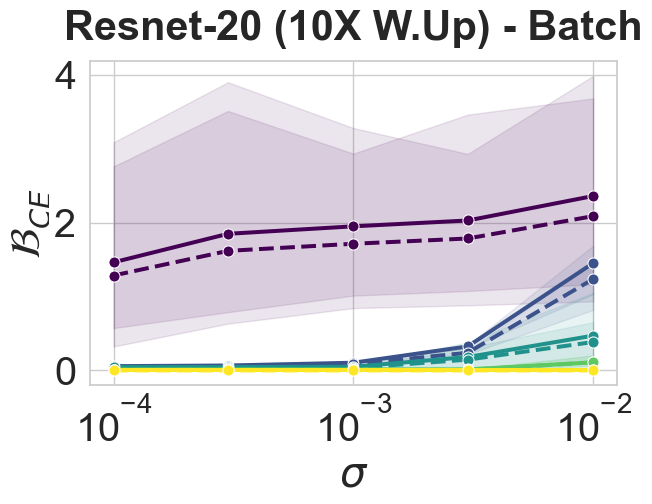

<Figure size 680.78x420.745 with 0 Axes>

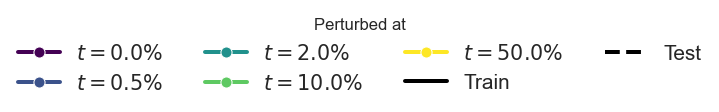

80
hello perturb_scale perturb_scale False


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


Saved legend to out/butterfly/warmup-10x-sanity-batch-perm-wm-0-1-loss-weighted-barrier-legend.pdf
Saved figure to out/butterfly/warmup-10x-sanity-batch-perm-wm-0-1-loss-weighted-barrier.pdf


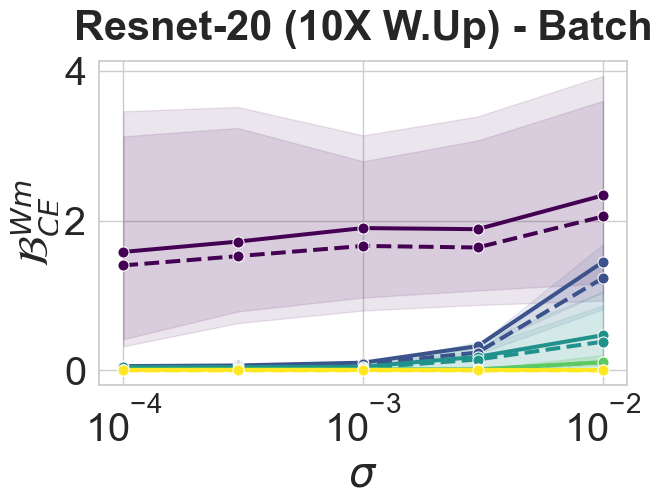

<Figure size 680.78x420.745 with 0 Axes>

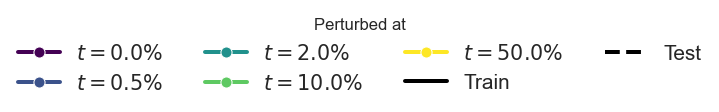

76
hello perturb_scale perturb_scale False


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


Saved legend to out/butterfly/warmup-10x-sanity-gaussian-lmc-0-1-loss-weighted-barrier-legend.pdf
Saved figure to out/butterfly/warmup-10x-sanity-gaussian-lmc-0-1-loss-weighted-barrier.pdf


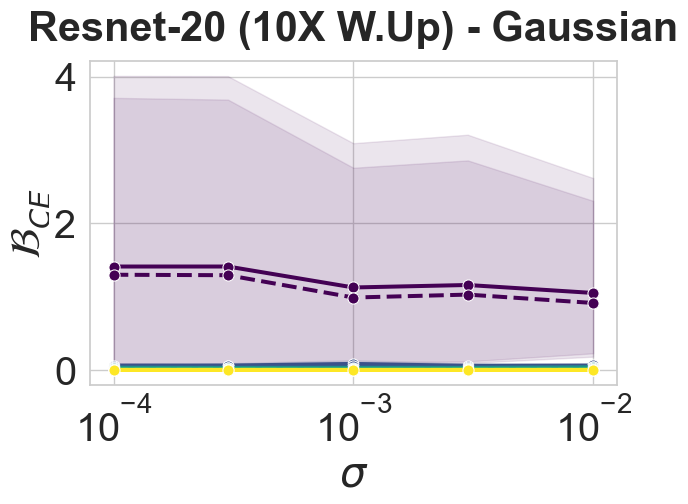

<Figure size 680.78x420.745 with 0 Axes>

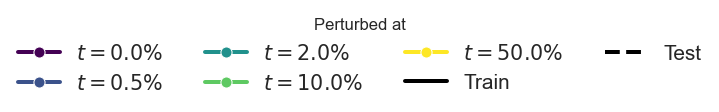

76
hello perturb_scale perturb_scale False


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


Saved legend to out/butterfly/warmup-10x-sanity-gaussian-perm-wm-0-1-loss-weighted-barrier-legend.pdf
Saved figure to out/butterfly/warmup-10x-sanity-gaussian-perm-wm-0-1-loss-weighted-barrier.pdf


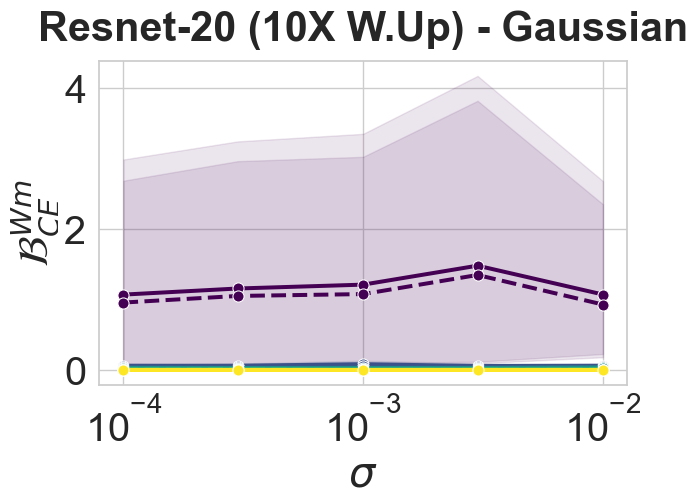

<Figure size 680.78x420.745 with 0 Axes>

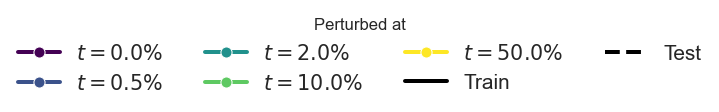

In [74]:
group = "warmup-10x-sanity"
filters = merged_df["run.group"] == group

for perturb_method in ["batch", "gaussian"]:
    for base_prefix in ["lmc", "perm_wm"]:
        base_name = f"{base_prefix}_loss_train_0_1"
        zoom = None
        x_metric = "perturb_scale"
        legend_template = r"$t={} \%$"
        labels = ["perturb_step_relative"]

        tmp = merged_df[filters & (merged_df["perturb_mode"] == perturb_method)]
        print(len(tmp))
        title = f"ResNet-20 (10x W.up) - {perturb_method}".title()
        t = plot_perturb_barrier(
            tmp,
            registry,
            perturb_method,
            base_name,
            zoom=zoom,
            filter_bad_runs=False,
            separate_legend=True,
            plot_type="line",
            title=title,
            x_metric=x_metric,
            labels=labels,
            legend_template=legend_template,
            legend_title="Perturbed at",
            hue_cnt=5,
            ncols=4,
            save_fig=True,
            xscale="log",
            save_prefix=group,
            out_dir=out
        )

### combo-wsup-sanity


In [75]:
filters = pv.reset_index()["run.group"] == "combo-wsup-sanity"
pv.reset_index()[filters]

## ResNet-8/64, SGD, lr=0.1, warmup=0.2, triangle scheduler, bs=128, 25000 steps, wd=0

run.group model.model_name trainer.opt.optimizer trainer.opt.lr  \
                                                                               
110  combo-wsup-sanity       resnet8-64                   sgd            0.1   
111  combo-wsup-sanity       resnet8-64                   sgd            0.1   
112  combo-wsup-sanity       resnet8-64                   sgd            0.1   
113  combo-wsup-sanity       resnet8-64                   sgd            0.1   
114  combo-wsup-sanity       resnet8-64                   sgd            0.1   
115  combo-wsup-sanity       resnet8-64                   sgd            0.1   
116  combo-wsup-sanity       resnet8-64                   sgd            0.1   
117  combo-wsup-sanity       resnet8-64                   sgd            0.1   
118  combo-wsup-sanity       resnet8-64                   sgd            0.1   
119  combo-wsup-sanity       resnet8-64                   sgd            0.1   
120  combo-wsup-sanity       resnet8-64                   sgd            0.1   
121  combo-wsup-sanity       resnet8-64                   sgd            0.1   
122  combo-wsup-sanity       resnet8-64                   sgd            0.1   
123  combo-wsup-sanity       resnet8-64                   sgd            0.1   
124  combo-wsup-sanity       resnet8-64                   sgd            0.1   
125  combo-wsup-sanity       resnet8-64                   sgd            0.1   
126  combo-wsup-sanity       resnet8-64                   sgd            0.1   
127  combo-wsup-sanity       resnet8-64                   sgd            0.1   
128  combo-wsup-sanity       resnet8-64                   sgd            0.1   
129  combo-wsup-sanity       resnet8-64                   sgd            0.1   
130  combo-wsup-sanity       resnet8-64                   sgd            0.1   
131  combo-wsup-sanity       resnet8-64                   sgd            0.1   
132  combo-wsup-sanity       resnet8-64                   sgd            0.1   
133  combo-wsup-sanity       resnet8-64                   sgd            0.1   
134  combo-wsup-sanity       resnet8-64                   sgd            0.1   
135  combo-wsup-sanity       resnet8-64                   sgd            0.1   
136  combo-wsup-sanity       resnet8-64                   sgd            0.1   
137  combo-wsup-sanity       resnet8-64                   sgd            0.1   
138  combo-wsup-sanity       resnet8-64                   sgd            0.1   
139  combo-wsup-sanity       resnet8-64                   sgd            0.1   
140  combo-wsup-sanity       resnet8-64                   sgd            0.1   
141  combo-wsup-sanity       resnet8-64                   sgd            0.1   
142  combo-wsup-sanity       resnet8-64                   sgd            0.1   
143  combo-wsup-sanity       resnet8-64                   sgd            0.1   
144  combo-wsup-sanity       resnet8-64                   sgd            0.1   
145  combo-wsup-sanity       resnet8-64                   sgd            0.1   
146  combo-wsup-sanity       resnet8-64                   sgd            0.1   
147  combo-wsup-sanity       resnet8-64                   sgd            0.1   
148  combo-wsup-sanity       resnet8-64                   sgd            0.1   
149  combo-wsup-sanity       resnet8-64                   sgd            0.1   
150  combo-wsup-sanity       resnet8-64                   sgd            0.1   
151  combo-wsup-sanity       resnet8-64                   sgd            0.1   
152  combo-wsup-sanity       resnet8-64                   sgd            0.1   
153  combo-wsup-sanity       resnet8-64                   sgd            0.1   
154  combo-wsup-sanity       resnet8-64                   sgd            0.1   
155  combo-wsup-sanity       resnet8-64                   sgd            0.1   
156  combo-wsup-sanity       resnet8-64                   sgd            0.1   
157  combo-wsup-sanity       resnet8-64                   sgd            0.1   
158  combo-ws

73
hello perturb_scale perturb_scale False


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


Saved legend to out/butterfly/combo-wsup-sanity-batch-lmc-0-1-loss-weighted-barrier-legend.pdf
Saved figure to out/butterfly/combo-wsup-sanity-batch-lmc-0-1-loss-weighted-barrier.pdf


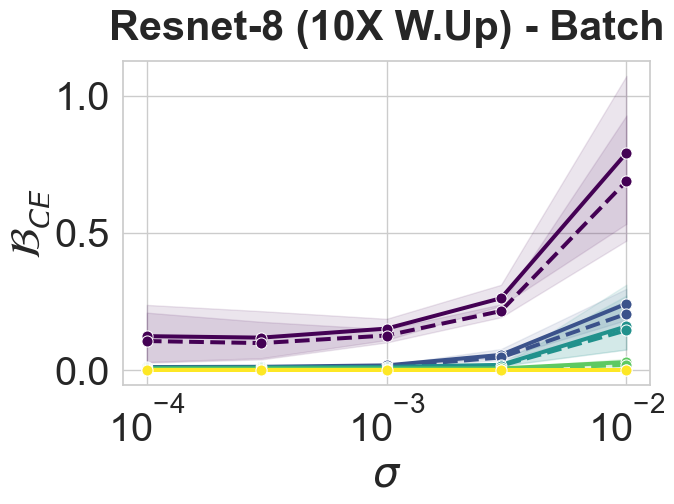

<Figure size 680.78x420.745 with 0 Axes>

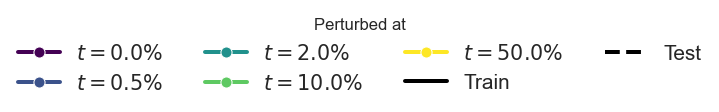

73
hello perturb_scale perturb_scale False


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


Saved legend to out/butterfly/combo-wsup-sanity-batch-perm-wm-0-1-loss-weighted-barrier-legend.pdf
Saved figure to out/butterfly/combo-wsup-sanity-batch-perm-wm-0-1-loss-weighted-barrier.pdf


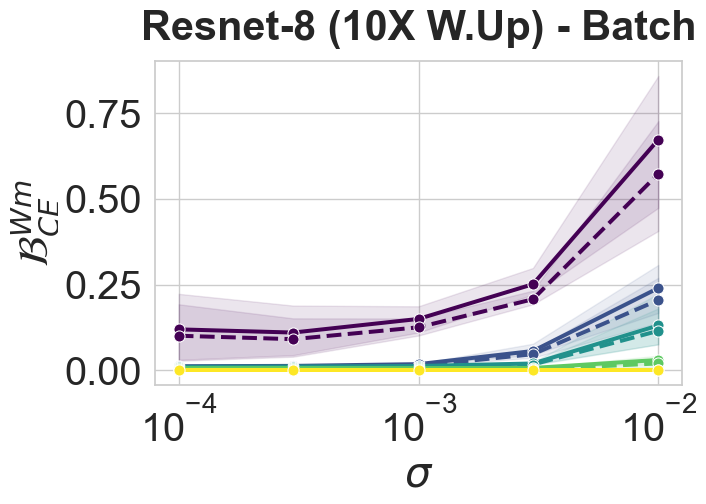

<Figure size 680.78x420.745 with 0 Axes>

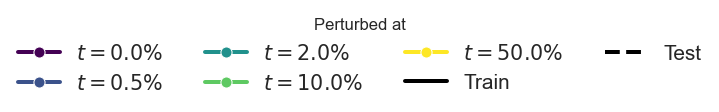

70
hello perturb_scale perturb_scale False


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


Saved legend to out/butterfly/combo-wsup-sanity-gaussian-lmc-0-1-loss-weighted-barrier-legend.pdf
Saved figure to out/butterfly/combo-wsup-sanity-gaussian-lmc-0-1-loss-weighted-barrier.pdf


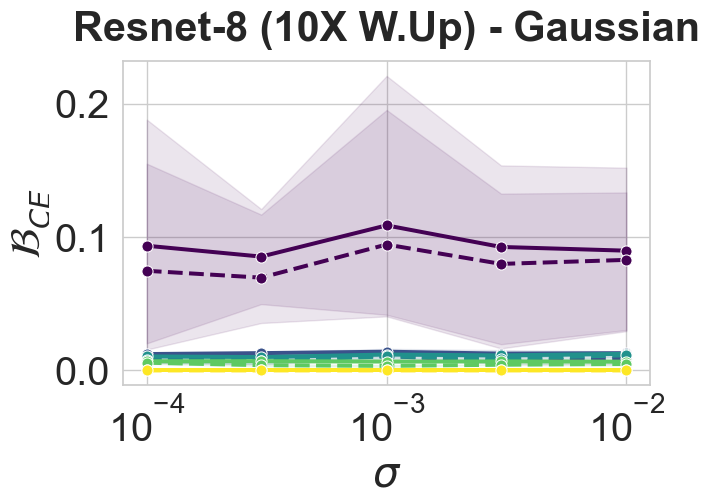

<Figure size 680.78x420.745 with 0 Axes>

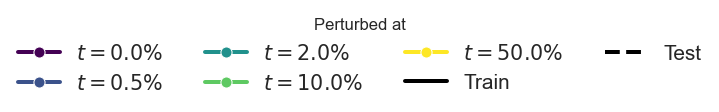

70
hello perturb_scale perturb_scale False


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


Saved legend to out/butterfly/combo-wsup-sanity-gaussian-perm-wm-0-1-loss-weighted-barrier-legend.pdf
Saved figure to out/butterfly/combo-wsup-sanity-gaussian-perm-wm-0-1-loss-weighted-barrier.pdf


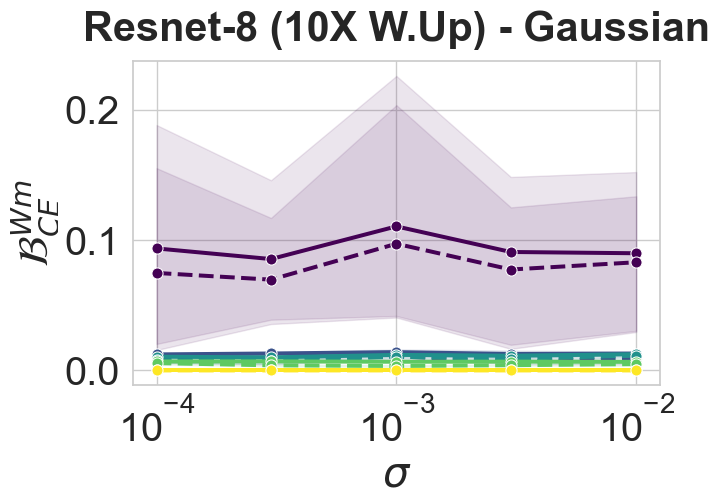

<Figure size 680.78x420.745 with 0 Axes>

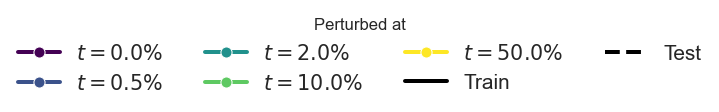

In [76]:
group = "combo-wsup-sanity"
filters = merged_df["run.group"] == group

for perturb_method in ["batch", "gaussian"]:
    for base_prefix in ["lmc", "perm_wm"]:
        base_name = f"{base_prefix}_loss_train_0_1"
        zoom = None
        x_metric = "perturb_scale"
        legend_template = r"$t={} \%$"
        labels = ["perturb_step_relative"]

        tmp = merged_df[filters & (merged_df["perturb_mode"] == perturb_method)]
        print(len(tmp))
        title = f"ResNet-8 (10x W.up) - {perturb_method}".title()
        t = plot_perturb_barrier(
            tmp,
            registry,
            perturb_method,
            base_name,
            zoom=zoom,
            filter_bad_runs=False,
            separate_legend=True,
            plot_type="line",
            title=title,
            x_metric=x_metric,
            labels=labels,
            legend_template=legend_template,
            legend_title="Perturbed at",
            hue_cnt=5,
            ncols=4,
            save_fig=True,
            xscale="log",
            save_prefix=group,
            out_dir=out
        )

# Barrier vs L2, Barrier vs. Fixed Points

Text(0.5, 1.04, 'Barrier vs. $L^2$ Dist.')

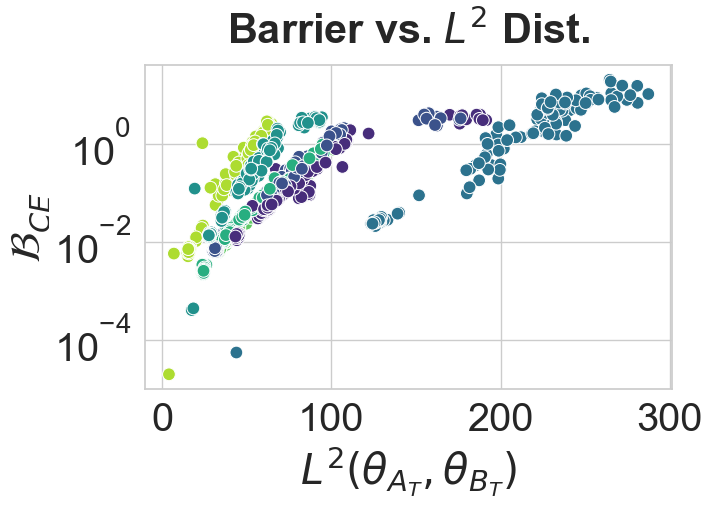

<Figure size 680.78x420.745 with 0 Axes>

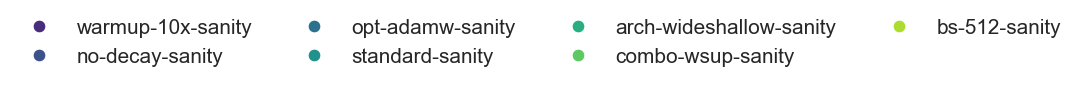

In [133]:
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
# mpl.rcParams['text.latex.preamble'] = ['\usepackage{amsmath}'] #for \text command


# Get the first color of the viridis colormap
viridis = plt.cm.viridis
first_color = viridis(0)  # First color corresponds to value 0

setup_styles(2)

filtered_df = merged_df.copy()
filtered_df = merged_df[~merged_df["run.group"].str.contains("lyapunov", regex=True)]

y = registry.get_metric("lmc_loss_train_0_1")
x = registry.get_metric("l2_dist_from_init_1")
x = registry.get_metric("l2_dist_1-2")

ax = sns.scatterplot(filtered_df, x=x.flat_name, y=y.flat_name, palette="viridis", hue="run.group")#color=first_color)
extract_legend(ax, ncol=4, add_tr_te=False)

ax.set_xlabel(r"$L^2 (\theta_{A_T}, \theta_{B_T})$")
ax.set_ylabel(y.general_ylabel)
ax.set_yscale("log")
title = r"Barrier vs. $L^2$ Dist."
ax.set_title("\n".join(wrap(title)))



# Get the first color of the viridis colormap
viridis = plt.cm.viridis
first_color = viridis(0)  # First color corresponds to value 0

setup_styles(2)

y = registry.get_metric("lmc_loss_train_0_1")
x = registry.get_metric("l2_dist_from_init_1")
# x = registry.get_metric("l2_dist_1-2")

filtered_df = merged_df.copy()
filtered_df = merged_df[~merged_df["run.group"].str.contains("lyapunov", regex=True)]

ax = sns.scatterplot(filtered_df, x=x.flat_name, y=y.flat_name, palette="viridis", hue="run.group")
extract_legend(ax, ncol=4, add_tr_te=False)

ax.set_xlabel(r"$L^2$ From Init.")
ax.set_ylabel(y.general_ylabel)
ax.set_xscale("log")
title = r"Barrier vs.$L^2$ Dist."
ax.set_title("\n".join(wrap(title)))


In [ ]:
filters = pv.reset_index()["run.group"] == "no-decay-sanity"
pv.reset_index()[filters]

## ResNet-20, SGD, lr=0.1, warmup=0.02, triangle scheduler, bs=128, 25000 steps, wd=0

run.group model.model_name trainer.opt.optimizer trainer.opt.lr  \
                                                                             
160  no-decay-sanity      resnet20-32                   sgd            0.1   
161  no-decay-sanity      resnet20-32                   sgd            0.1   
162  no-decay-sanity      resnet20-32                   sgd            0.1   
163  no-decay-sanity      resnet20-32                   sgd            0.1   
164  no-decay-sanity      resnet20-32                   sgd            0.1   
165  no-decay-sanity      resnet20-32                   sgd            0.1   
166  no-decay-sanity      resnet20-32                   sgd            0.1   
167  no-decay-sanity      resnet20-32                   sgd            0.1   
168  no-decay-sanity      resnet20-32                   sgd            0.1   
169  no-decay-sanity      resnet20-32                   sgd            0.1   
170  no-decay-sanity      resnet20-32                   sgd            0.1   
171  no-decay-sanity      resnet20-32                   sgd            0.1   
172  no-decay-sanity      resnet20-32                   sgd            0.1   
173  no-decay-sanity      resnet20-32                   sgd            0.1   
174  no-decay-sanity      resnet20-32                   sgd            0.1   
175  no-decay-sanity      resnet20-32                   sgd            0.1   
176  no-decay-sanity      resnet20-32                   sgd            0.1   
177  no-decay-sanity      resnet20-32                   sgd            0.1   
178  no-decay-sanity      resnet20-32                   sgd            0.1   
179  no-decay-sanity      resnet20-32                   sgd            0.1   
180  no-decay-sanity      resnet20-32                   sgd            0.1   
181  no-decay-sanity      resnet20-32                   sgd            0.1   
182  no-decay-sanity      resnet20-32                   sgd            0.1   
183  no-decay-sanity      resnet20-32                   sgd            0.1   
184  no-decay-sanity      resnet20-32                   sgd            0.1   
185  no-decay-sanity      resnet20-32                   sgd            0.1   
186  no-decay-sanity      resnet20-32                   sgd            0.1   
187  no-decay-sanity      resnet20-32                   sgd            0.1   
188  no-decay-sanity      resnet20-32                   sgd            0.1   
189  no-decay-sanity      resnet20-32                   sgd            0.1   
190  no-decay-sanity      resnet20-32                   sgd            0.1   
191  no-decay-sanity      resnet20-32                   sgd            0.1   
192  no-decay-sanity      resnet20-32                   sgd            0.1   
193  no-decay-sanity      resnet20-32                   sgd            0.1   
194  no-decay-sanity      resnet20-32                   sgd            0.1   
195  no-decay-sanity      resnet20-32                   sgd            0.1   
196  no-decay-sanity      resnet20-32                   sgd            0.1   
197  no-decay-sanity      resnet20-32                   sgd            0.1   
198  no-decay-sanity      resnet20-32                   sgd            0.1   
199  no-decay-sanity      resnet20-32                   sgd            0.1   
200  no-decay-sanity      resnet20-32                   sgd            0.1   
201  no-decay-sanity      resnet20-32                   sgd            0.1   
202  no-decay-sanity      resnet20-32                   sgd            0.1   
203  no-decay-sanity      resnet20-32                   sgd            0.1   
204  no-decay-sanity      resnet20-32                   sgd            0.1   
205  no-decay-sanity      resnet20-32                   sgd            0.1   
206  no-decay-sanity      resnet20-32                   sgd            0.1   
207  no-decay-sanity      resnet20-32                   sgd            0.1   
208  no-decay-sanity      resnet20-32                   sgd            0.1   
209  no-decay-sanity      resnet2

76
hello perturb_scale perturb_scale False


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


Saved legend to out/butterfly/no-decay-sanity-batch-lmc-0-1-loss-weighted-barrier-legend.pdf
Saved figure to out/butterfly/no-decay-sanity-batch-lmc-0-1-loss-weighted-barrier.pdf


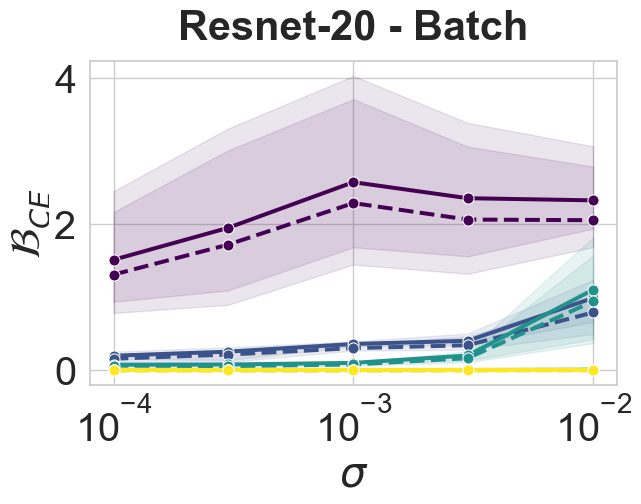

<Figure size 680.78x420.745 with 0 Axes>

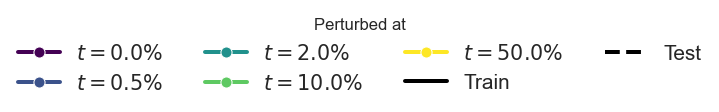

76
hello perturb_scale perturb_scale False


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


Saved legend to out/butterfly/no-decay-sanity-batch-perm-wm-0-1-loss-weighted-barrier-legend.pdf
Saved figure to out/butterfly/no-decay-sanity-batch-perm-wm-0-1-loss-weighted-barrier.pdf


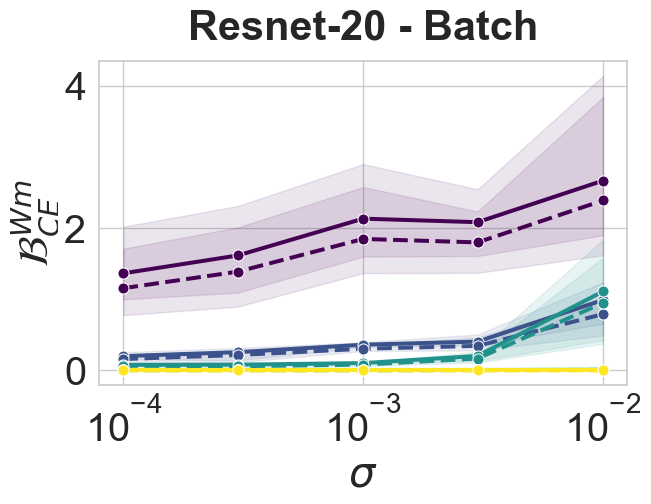

<Figure size 680.78x420.745 with 0 Axes>

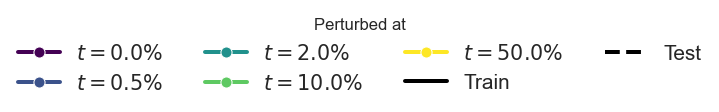

71
hello perturb_scale perturb_scale False


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


Saved legend to out/butterfly/no-decay-sanity-gaussian-lmc-0-1-loss-weighted-barrier-legend.pdf
Saved figure to out/butterfly/no-decay-sanity-gaussian-lmc-0-1-loss-weighted-barrier.pdf


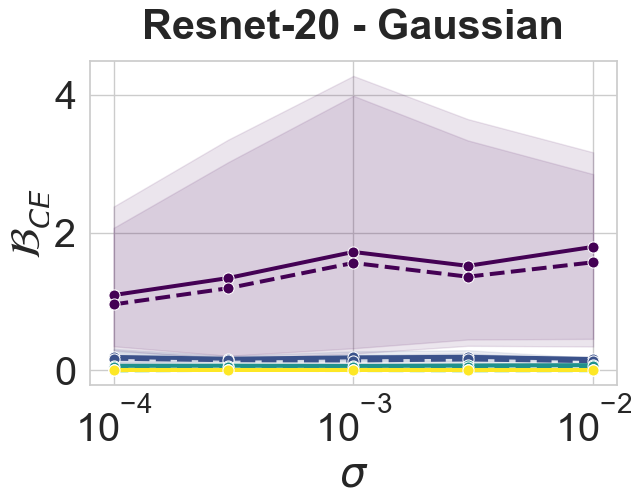

<Figure size 680.78x420.745 with 0 Axes>

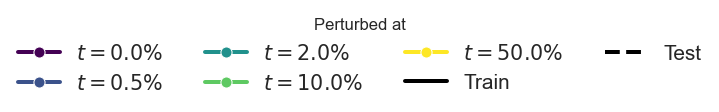

71
hello perturb_scale perturb_scale False


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:138: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


Saved legend to out/butterfly/no-decay-sanity-gaussian-perm-wm-0-1-loss-weighted-barrier-legend.pdf
Saved figure to out/butterfly/no-decay-sanity-gaussian-perm-wm-0-1-loss-weighted-barrier.pdf


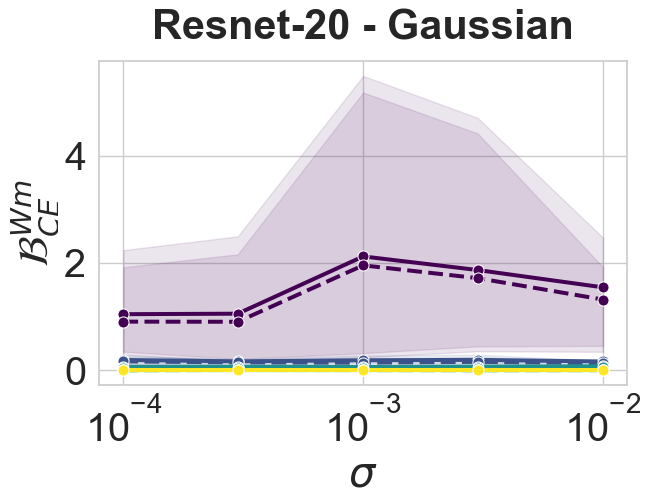

<Figure size 680.78x420.745 with 0 Axes>

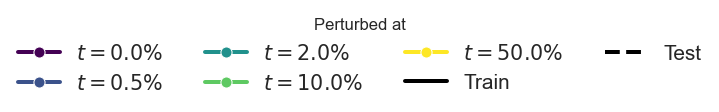

In [ ]:
group = "no-decay-sanity"
filters = ((merged_df["run.group"] == group ))

for perturb_method in ["batch", "gaussian"]:
    for base_prefix in ["lmc", "perm_wm"]:
        base_name = f"{base_prefix}_loss_train_0_1"
        zoom = None
        x_metric = "perturb_scale"
        legend_template = r"$t={} \%$"
        labels = ["perturb_step_relative"]
            
        tmp = merged_df[filters & (merged_df["perturb_mode"] == perturb_method)]
        print(len(tmp))
        title = f"ResNet-20 - {perturb_method}".title()
        t = plot_perturb_barrier(
            tmp,
            registry,
            perturb_method,
            base_name,
            zoom=zoom,
            filter_bad_runs=False,
            separate_legend=True,
            plot_type="line",
            title=title,
            x_metric=x_metric,
            labels=labels,
            legend_template=legend_template,
            legend_title="Perturbed at",
            hue_cnt=5,
            ncols=4,
            save_fig=True,
            xscale="log",
            save_prefix=group,
            out_dir=out,
        )

Text(0.5, 1.04, 'Barrier vs. WM Fixed Points')

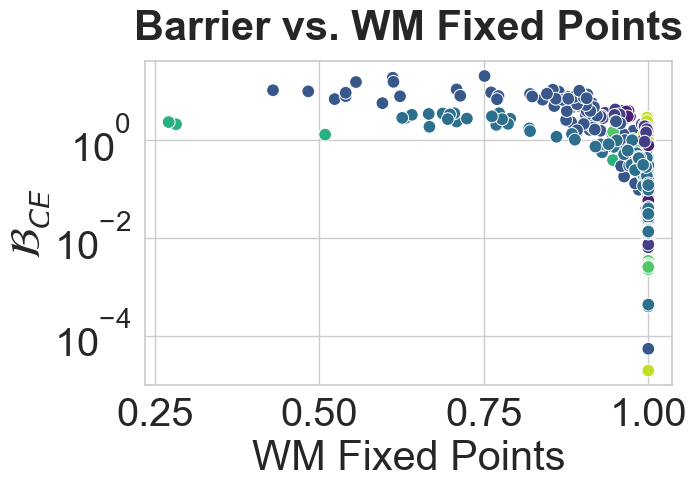

<Figure size 680.78x420.745 with 0 Axes>

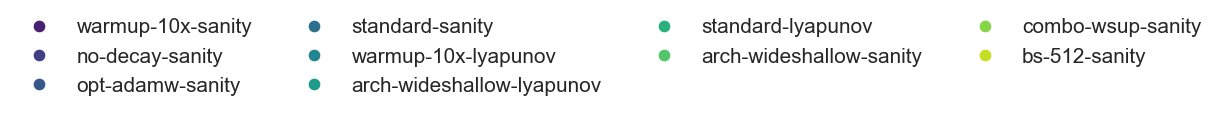

In [131]:
# Get the first color of the viridis colormap
viridis = plt.cm.viridis
first_color = viridis(0)  # First color corresponds to value 0

setup_styles(2)

y = registry.get_metric("lmc_loss_train_0_1")
x = registry.get_metric("l2_dist_from_init_1")
x = registry.get_metric("l2_dist_from_init_1")
x = registry.get_metric("perm_wm_fixed_ponts_1_2")

filtered_df = merged_df.copy()
filtered_df = merged_df[~merged_df["run.group"].str.contains("lyapunov", regex=True)]

ax = sns.scatterplot(merged_df, x=x.flat_name, y=y.flat_name, palette="viridis", hue="run.group")
# ax.legend(False)
extract_legend(ax, ncol=4, add_tr_te=False)

ax.set_xlabel(r"WM Fixed Points")
ax.set_ylabel(y.general_ylabel)
ax.set_yscale("log")
title = r"Barrier vs. WM Fixed Points"
ax.set_title("\n".join(wrap(title)))
